- The main objective is to predict people with pre-diabetes. 
- Available data is rows-664653 and columns-67. Other than this demographics data is available.
- In this file, both data files will be combined and exploratory data analysis will be performed on the final data,
- Cleaning also be done side wise side wherever it is required and final data will be saved in s3

In [2]:
!pip install --upgrade pandas --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple

Keyring is skipped due to an exception: 'keyring.backends'
Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple


In [3]:
!pip install --upgrade numpy --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple

Keyring is skipped due to an exception: 'keyring.backends'
Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple


In [4]:
!pip install awswrangler --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple

Keyring is skipped due to an exception: 'keyring.backends'
Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple
  Using cached https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/packages/packages/72/4d/b45ac72620e0232706e78c0e92a28f7244d810b46762b20c25ac354974dc/awswrangler-2.17.0-py3-none-any.whl (251 kB)
  Using cached https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/packages/packages/af/7d/94064bf0b44cf9e3cf67bdb90735f01d1d53a3973f8d59da99dc9ed58303/pyarrow-8.0.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (29.3 MB)
  Using cached https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/packages/packages/13/97/128668e1e4456c2f1c2f65930f2336146f9145bbe00ee3f0fe8c63437259/opensearch_py-2.0.0-py2.py3-none-any.whl (204 kB)
  Using cached https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/packages/packages/a5/dd/fc1372e19edffa0ef38ff4ea243f79101d69cf899a3

In [5]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline

import awswrangler
import warnings
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import boto3
import io

pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [6]:
s3 = boto3.client('s3')

# Mention the bucket name where raw data is present
bucket='adl-core-sagemaker-studio'

# This is used to seperate different versions of data for whole lifecycle i.e., data pre-process, transformations, modeling and inferences.
# Mention the version whre data is stored in given S3 bucket
version = 'version-1'

# Mention the correct directory where raw-data is present, if data is in multiple files make sure all files are present in this directory
raw_data_path = f'external/artichauhan/Pre-Diabetes/Raw Data'

preprocessed_data = f'external/artichauhan/Pre-Diabetes/Preprocessed-Data'

raw_data_fnames = ['Hype_ML_demographics_19_20_21_1.csv','Hype_ML_demographics_19_20_21_2.csv']

s3://adl-core-sagemaker-studio/external/artichauhan/Pre-Diabetes/Raw Data/data in parquet format/

In [7]:
# # Retrieve the list of existing buckets
# s3 = boto3.client("s3")
# response = s3.list_buckets()

# # Output the bucket names
# print("Existing buckets:")
# for bucket in response['Buckets']:
#     print(f'{bucket["Name"]}')

In [8]:
# df = dd.read_parquet(f's3://{bucket}/{raw_data_path}/data in parquet format/*.parquet',engine='pyarrow')
# #converting dask df to pandas df 
# df = df.compute()
# df.head()

""


In [13]:
import awswrangler as wr
df = wr.s3.read_parquet(f's3://{bucket}/{raw_data_path}/data in parquet format')

In [14]:
df.shape

(664653, 67)

In [8]:
df['pre_diabetic_label'].unique()

array(['Yes', 'No'], dtype=object)

In [9]:
len(df[df['pre_diabetic_label'] == 'NULL']['pre_diabetic_label'])

0

In [10]:
round(len(df[df['pre_diabetic_label'] == 'NULL']['pre_diabetic_label'])/len(df.index),2)

0.0

In [11]:
df.isna().sum()

person_internal_id        0
partneremployerid         0
patient_key               0
pre_diabetic_label        0
tot_billed_amt_yr_0       0
                         ..
physician_ind_y1          0
outpatient_ind_y1         0
unknown_ind_y1            0
durable_medical_ind_y1    0
lab_visit_ind_y1          0
Length: 67, dtype: int64

In [12]:
threshold = 0.1
na_col = df.isna().sum().div(len(df.index))              # average na by column
cols = na_col[na_col > threshold].keys().to_list() 
print(cols)

[]


In [13]:
def load_data_from_s3(bucket,raw_data_path,raw_data_fnames):
    s3 = boto3.client('s3')
    dataset_nrows = []
    for i, fname in enumerate(raw_data_fnames):
        if i==0:
            print(f'Reading file: {fname}')
            key = f'{raw_data_path}/{fname}'
            obj = s3.get_object(Bucket=bucket, Key=key)
            data = pd.read_csv(io.BytesIO(obj['Body'].read()))
            dataset_nrows.append(data.shape[0])
            print(f'\tFile read successfully | Shape: {data.shape}')
        else:
            print(f'Reading file: {fname}')
            key = f'{raw_data_path}/{fname}'
            obj = s3.get_object(Bucket=bucket, Key=key)
            data2 = pd.read_csv(io.BytesIO(obj['Body'].read()))
            data = data.append(data2,ignore_index=True)
            dataset_nrows.append(data2.shape[0])
            print(f'\tFile read successfully | Shape: {data2.shape}')

    if sum(dataset_nrows) == data.shape[0]:
        print(f'Data from all files loaded successfully | Final Shape: {data.shape}')
        return data.copy()
    else:
        print('There is discrepency in numbers')
        print(f'\tTotal number of rows combined in all files: {sum(dataset_nrows)}')
        print(f'\tAfter combining all files total number of rows are: {data.shape[0]}')
        return None

In [14]:
data_path = f'{raw_data_path}/Demographics files'
demo_df = load_data_from_s3(bucket,data_path,raw_data_fnames)

Reading file: Hype_ML_demographics_19_20_21_1.csv
	File read successfully | Shape: (2242551, 35)
Reading file: Hype_ML_demographics_19_20_21_2.csv
	File read successfully | Shape: (2082214, 35)
Data from all files loaded successfully | Final Shape: (4324765, 35)


In [15]:
demo_df.head(2)

,person_internal_id,client_id,udp_global_id,age,gender,marital_status,is_union,primary_language_code,country_description,state,platform_indicator_code,mapped_employment_status_code,mapped_employment_status_description,mapped_fullpart_code,mapped_fullpart_description,mapped_high_compensation_code,mapped_high_compensation_description,mapped_permanent_temporary_code,mapped_permanent_temporary_description,mapped_hourly_salary_code,mapped_hourly_salary_description,subsidiary_code,subsidiary_description,mapped_flex_status_code,mapped_flex_status_description,original_hire_date,rehire_date,is_rehire,termination_date,base_pay_regular_payrate_amount,base_pay_regular_frequency_code,base_pay_regular_frequency_description,base_pay_regular_expectedannualsalary,base_pay_regular_expectedannualsalary_range,annual_benefits_base_rate
0,359000077,3349,58a39c4f042fec2f071a7119,74.0,F,S,N,NaN,United States of America,TX,R4,RTEE,Retired,FLTM,Full Time,NaN,NaN,PERM,Permanent,NaN,NaN,NaN,NaN,ELIGIBLE,Eligible,1970-02-27,NaN,N,2299-12-31,35626.50,A1,Annual,35626.50,"$20,000-$39,999",NaN
1,231200007,3955,59056881dab54b31271989ea,58.0,M,M,N,AE,United States of America,MD,R4,ACTIVE,Active,FLTM,Full Time,NaN,NaN,PERM,Permanent,NaN,NaN,NaN,NaN,ELIGIBLE,Eligible,NaN,NaN,N,2299-12-31,104499.24,A1,Annual,104499.24,"$100,000-$174,999",NaN


In [16]:
demo_df['client_pid'] = demo_df['client_id'].astype(str) + '/' +  demo_df['person_internal_id'].astype(str)

In [17]:
df['client_pid'] = df['partneremployerid'].astype(str) + '/' +  df['person_internal_id'].astype(str)

In [18]:
pd_df = df.merge(demo_df,how='left',on='client_pid')

In [19]:
pd_df.head(2)

,person_internal_id_x,partneremployerid,patient_key,pre_diabetic_label,tot_billed_amt_yr_0,avg_billed_amt_yr_0,std_billed_amt_yr_0,max_billed_amt_yr_0,employer_paid_yr_0,employee_paid1_yr_0,employee_paid2_yr_0,paid_thr_deduct_yr_0,tot_billed_amt_yr_1,avg_billed_amt_yr_1,std_billed_amt_yr_1,max_billed_amt_yr_1,employer_paid_yr_1,employee_paid1_yr_1,employee_paid2_yr_1,paid_thr_deduct_yr_1,tot_billed_amt_yr,avg_billed_amt_yr,std_billed_amt_yr,max_billed_amt_yr,employer_paid_yr,employee_paid1_yr,employee_paid2_yr,paid_thr_deduct_yr,screening_flag_yr_0,sleep_apnea_flag_yr_0,cushing_flag_yr_0,acromegaly_flag_yr_0,urinary_flag_yr_0,screening_flag_yr_1,sleep_apnea_flag_yr_1,cushing_flag_yr_1,acromegaly_flag_yr_1,urinary_flag_yr_1,screening_flag_yr,sleep_apnea_flag_yr,cushing_flag_yr,acromegaly_flag_yr,urinary_flag_yr,specialist_ind,primary_care_ind,inpatient_ind,physician_ind,outpatient_ind,unknown_ind,durable_medical_ind,lab_visit_ind,specialist_ind_y0,primary_care_ind_y0,inpatient_ind_y0,physician_ind_y0,outpatient_ind_y0,unknown_ind_y0,durable_medical_ind_y0,lab_visit_ind_y0,specialist_ind_y1,primary_care_ind_y1,inpatient_ind_y1,physician_ind_y1,outpatient_ind_y1,unknown_ind_y1,durable_medical_ind_y1,lab_visit_ind_y1,client_pid,person_internal_id_y,client_id,udp_global_id,age,gender,marital_status,is_union,primary_language_code,country_description,state,platform_indicator_code,mapped_employment_status_code,mapped_employment_status_description,mapped_fullpart_code,mapped_fullpart_description,mapped_high_compensation_code,mapped_high_compensation_description,mapped_permanent_temporary_code,mapped_permanent_temporary_description,mapped_hourly_salary_code,mapped_hourly_salary_description,subsidiary_code,subsidiary_description,mapped_flex_status_code,mapped_flex_status_description,original_hire_date,rehire_date,is_rehire,termination_date,base_pay_regular_payrate_amount,base_pay_regular_frequency_code,base_pay_regular_frequency_description,base_pay_regular_expectedannualsalary,base_pay_regular_expectedannualsalary_range,annual_benefits_base_rate
0,210000050,2265,78553718,Yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0000,0.000000,0.00,0.00,0.0,0.00,0.00,4505.17,95.854681,147.3198,806.05,3292.51,245.0,267.66,700.0,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,Yes,No,No,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,2265/210000050,210000050,2265,593253ee69b312120cd2b1f2,57.0,F,M,N,NaN,NaN,NaN,NaN,TERM,Termination,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOTELIGIBLE,Not Eligible,NaN,NaN,N,2022-03-12,124866.82,A1,Annual,124866.82,"$100,000-$174,999",NaN
1,133200030,1377,76251639,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,573.19,143.2975,142.888152,353.65,204.18,0.0,51.05,317.96,0.00,0.000000,0.0000,0.00,0.00,0.0,0.00,0.0,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,1377/133200030,133200030,1377,597d1d83dab54b2d66db9897,36.0,M,M,N,NaN,United States of America,OH,R3,ACTIVE,Active,FLTM,Full Time,NaN,NaN,PERM,Permanent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,2299-12-31,70075.20,A1,Annual,70075.20,"$60,000-$79,999",70075.2


In [20]:
pd_df.shape

(666085, 103)

In [21]:
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 666085 entries, 0 to 666084
Columns: 103 entries, person_internal_id_x to annual_benefits_base_rate
dtypes: float64(28), int32(3), int64(2), object(70)
memory usage: 520.9+ MB


In [22]:
pd_df[['client_id','partneremployerid','person_internal_id_x','person_internal_id_y']]

,client_id,partneremployerid,person_internal_id_x,person_internal_id_y
0,2265,2265,210000050,210000050
1,1377,1377,133200030,133200030
2,1040,1040,297600089,297600089
3,1040,1040,471410079,471410079
4,5977,5977,29100064,29100064
...,...,...,...,...
666080,9086,9086,266500035,266500035
666081,2346,2346,421310001,421310001
666082,1874,1874,202940018,202940018
666083,3349,3349,241390094,241390094


In [23]:
dup_df = pd_df[pd_df['client_pid'].duplicated()==True]

In [24]:
dup_df

,person_internal_id_x,partneremployerid,patient_key,pre_diabetic_label,tot_billed_amt_yr_0,avg_billed_amt_yr_0,std_billed_amt_yr_0,max_billed_amt_yr_0,employer_paid_yr_0,employee_paid1_yr_0,employee_paid2_yr_0,paid_thr_deduct_yr_0,tot_billed_amt_yr_1,avg_billed_amt_yr_1,std_billed_amt_yr_1,max_billed_amt_yr_1,employer_paid_yr_1,employee_paid1_yr_1,employee_paid2_yr_1,paid_thr_deduct_yr_1,tot_billed_amt_yr,avg_billed_amt_yr,std_billed_amt_yr,max_billed_amt_yr,employer_paid_yr,employee_paid1_yr,employee_paid2_yr,paid_thr_deduct_yr,screening_flag_yr_0,sleep_apnea_flag_yr_0,cushing_flag_yr_0,acromegaly_flag_yr_0,urinary_flag_yr_0,screening_flag_yr_1,sleep_apnea_flag_yr_1,cushing_flag_yr_1,acromegaly_flag_yr_1,urinary_flag_yr_1,screening_flag_yr,sleep_apnea_flag_yr,cushing_flag_yr,acromegaly_flag_yr,urinary_flag_yr,specialist_ind,primary_care_ind,inpatient_ind,physician_ind,outpatient_ind,unknown_ind,durable_medical_ind,lab_visit_ind,specialist_ind_y0,primary_care_ind_y0,inpatient_ind_y0,physician_ind_y0,outpatient_ind_y0,unknown_ind_y0,durable_medical_ind_y0,lab_visit_ind_y0,specialist_ind_y1,primary_care_ind_y1,inpatient_ind_y1,physician_ind_y1,outpatient_ind_y1,unknown_ind_y1,durable_medical_ind_y1,lab_visit_ind_y1,client_pid,person_internal_id_y,client_id,udp_global_id,age,gender,marital_status,is_union,primary_language_code,country_description,state,platform_indicator_code,mapped_employment_status_code,mapped_employment_status_description,mapped_fullpart_code,mapped_fullpart_description,mapped_high_compensation_code,mapped_high_compensation_description,mapped_permanent_temporary_code,mapped_permanent_temporary_description,mapped_hourly_salary_code,mapped_hourly_salary_description,subsidiary_code,subsidiary_description,mapped_flex_status_code,mapped_flex_status_description,original_hire_date,rehire_date,is_rehire,termination_date,base_pay_regular_payrate_amount,base_pay_regular_frequency_code,base_pay_regular_frequency_description,base_pay_regular_expectedannualsalary,base_pay_regular_expectedannualsalary_range,annual_benefits_base_rate
93,292501061,3349,78647695,No,0.00,0.000000,0.000000,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.000000,0.00,0.00,0.0,0.0,0.0,239.00,79.666667,48.583262,135.00,0.00,0.0,0.00,239.00,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,3349/292501061,292501061,3349,58a38d50f7a4410c158130ef,78.0,M,M,N,NaN,United States of America,MS,R4,RTEE,Retired,FLTM,Full Time,NaN,NaN,PERM,Permanent,NaN,NaN,NaN,NaN,ELIGIBLE,Eligible,1930-01-01,NaN,N,2299-12-31,NaN,NaN,NaN,NaN,NaN,NaN
113,246401005,3349,77678179,No,0.00,0.000000,0.000000,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.000000,0.00,0.00,0.0,0.0,0.0,4576.10,143.003125,240.858144,963.90,1624.37,0.0,305.56,2646.17,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,Yes,No,No,No,Yes,Yes,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,3349/246401005,246401005,3349,607a7ac99a2ea4540a2d695b,55.0,M,S,N,NaN,United States of America,GA,R4,ACTIVE,Active,FLTM,Full Time,NaN,NaN,PERM,Permanent,NaN,NaN,NaN,NaN,ELIGIBLE,Eligible,2021-04-12,NaN,N,2299-12-31,98800.00,A1,Annual,98800.00,"$80,000-$99,999",NaN
765,290401052,3349,77454188,No,0.00,0.000000,0.000000,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.000000,0.00,0.00,0.0,0.0,0.0,4130.74,114.742778,210.184668,1246.00,1079.29,0.0,0.00,3051.45,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,Yes,No,No,Yes,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,3349/290401052,290401052,3349,58a38f89f7a4410c1582f13c,87.0,F,M,N,NaN,United States of America,PA,R4,DCSD_INSV,Deceased - In Service,FLTM,Full Time,NaN,NaN,PERM,Permanent,NaN,NaN,NaN,NaN,ELIGIBLE,Eligible,1930-01-01,NaN,N,2299-12-31,NaN,NaN,NaN,NaN,NaN,NaN
843,52050020,5035,77726143,No,0.00,0.000000,0.000000,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.000000,0.00,0.00,0.0,0.0,0.0,194.28,5.112632,7.519340,24.83,18.50,0.0,0.00,175.78,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,Yes,No,Yes,No,No,No,No,No,No,No,No,No,No,No,N

In [25]:
new_pd_df = pd_df

In [26]:
# pd_df.drop_duplicates(keep='first',inplace=True)

In [27]:
# pd_df.shape

In [28]:
pd_df['duplicated'] = pd_df['client_pid'].duplicated()

In [29]:
pd_df['duplicated'].value_counts()

False    664581
True       1504
Name: duplicated, dtype: int64

In [30]:
final_df = pd_df[pd_df['duplicated']!=True]

In [31]:
final_df.shape

(664581, 104)

In [32]:
# for i in final_df.columns:
#     print(i)

In [33]:
columnList = ['duplicated','person_internal_id_y','partneremployerid']
final_df.drop(columns=columnList, axis=1, inplace=True)

In [34]:
final_df.rename(columns={'person_internal_id_x':'person_internal_id'},inplace=True)

In [35]:
final_df.shape

(664581, 101)

In [36]:
final_df['pre_diabetic_label'].value_counts()

No     515047
Yes    149534
Name: pre_diabetic_label, dtype: int64

In [37]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 664581 entries, 0 to 666084
Columns: 101 entries, person_internal_id to annual_benefits_base_rate
dtypes: float64(28), int32(2), int64(1), object(70)
memory usage: 512.1+ MB


In [38]:
df = final_df

In [39]:
# df['target'].value_counts(normalize=True)

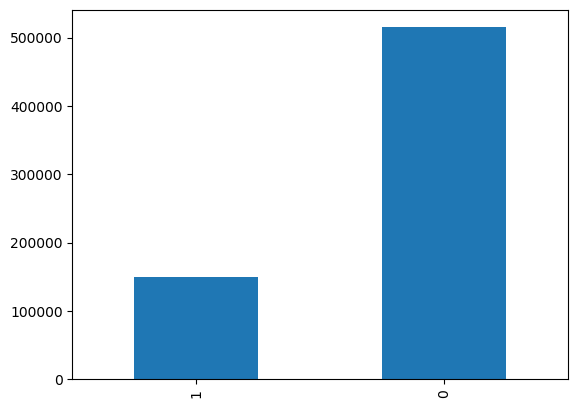

In [40]:
# target column
df["target"] = df["pre_diabetic_label"].map({"Yes":1,"No":0})
df["target"].value_counts().sort_values().plot(kind = 'bar')

In [41]:
def show_nans(table):
    '''
    Shows missing values count and percentage from highest to lowest
    '''
    nan_count = pd.DataFrame(table.isna().sum(), columns = ["actual_nan"])
    nan_count["percentage_missing"] = round(nan_count["actual_nan"]/table.shape[0],2)
    nan_count["column"] = nan_count.index
    nan_count.index = range(nan_count.shape[0])
    return nan_count.sort_values("percentage_missing",ascending=False)[["column","actual_nan","percentage_missing"]]

In [42]:
missing_df = show_nans(df)
missing_df[missing_df['percentage_missing']>0.0]

,column,actual_nan,percentage_missing
82,mapped_high_compensation_description,664576,1.00
81,mapped_high_compensation_code,568719,0.86
87,subsidiary_code,569354,0.86
88,subsidiary_description,569354,0.86
73,primary_language_code,553493,0.83
92,rehire_date,429302,0.65
85,mapped_hourly_salary_code,355008,0.53
86,mapped_hourly_salary_description,355008,0.53
100,annual_benefits_base_rate,289454,0.44
90,mapped_flex_status_description,256591,0.39


In [43]:
df.shape

(664581, 102)

In [44]:
cols_to_drop = missing_df[missing_df['percentage_missing']>0.30].column

In [45]:
perc = 30.0
min_count =  int(((100-perc)/100)*df.shape[0] + 1)
df = df.dropna( axis=1, 
                thresh=min_count)

In [46]:
df.shape

(664581, 88)

In [47]:
# df.select_dtypes('int').columns

In [48]:
# cols=df.select_dtypes('object').columns
# for i in cols:
#     if df[i].isnull().sum() > 0:
#         print(i)
#         print(df[i].isnull().sum())

In [49]:
cols=df.select_dtypes('float').columns
df[cols].describe()

,tot_billed_amt_yr_0,avg_billed_amt_yr_0,std_billed_amt_yr_0,max_billed_amt_yr_0,employer_paid_yr_0,employee_paid1_yr_0,employee_paid2_yr_0,paid_thr_deduct_yr_0,tot_billed_amt_yr_1,avg_billed_amt_yr_1,std_billed_amt_yr_1,max_billed_amt_yr_1,employer_paid_yr_1,employee_paid1_yr_1,employee_paid2_yr_1,paid_thr_deduct_yr_1,tot_billed_amt_yr,avg_billed_amt_yr,std_billed_amt_yr,max_billed_amt_yr,employer_paid_yr,employee_paid1_yr,employee_paid2_yr,paid_thr_deduct_yr,age,base_pay_regular_payrate_amount,base_pay_regular_expectedannualsalary
count,6.645810e+05,664581.000000,664581.000000,6.645810e+05,6.645810e+05,664581.000000,664581.000000,664581.000000,6.645810e+05,664581.000000,664581.000000,6.645810e+05,6.645810e+05,664581.000000,664581.000000,664581.000000,6.645810e+05,664581.000000,664581.000000,6.645810e+05,6.645810e+05,664581.000000,664581.000000,664581.000000,664483.000000,6.292440e+05,6.294500e+05
mean,5.082631e+03,96.929377,251.935553,1.845274e+03,4.338419e+03,41.332333,259.505462,461.529371,3.340721e+03,74.974400,187.500887,1.265180e+03,2.772537e+03,29.524257,200.843026,356.032278,6.620727e+03,122.871924,324.469930,2.411579e+03,5.601812e+03,55.548718,328.785495,621.960771,47.155769,9.003401e+04,9.132704e+04
std,2.549875e+04,195.576988,962.035959,1.150908e+04,2.499800e+04,136.108674,751.761266,787.741437,1.815703e+04,208.412640,795.008803,8.434504e+03,1.764039e+04,114.405820,718.753962,771.891287,2.939217e+04,218.496422,1098.997248,1.408858e+04,2.881221e+04,155.406880,942.334598,925.625208,13.367262,4.191732e+05,4.189331e+05
min,-9.818706e+04,-688.597538,0.000000,-3.240900e+02,-1.004371e+05,-250.000000,-5034.520000,-9494.720000,-1.064651e+05,-11018.395000,0.000000,-8.129090e+03,-1.060451e+05,-1140.000000,-46458.230000,-12633.880000,-1.379117e+05,-15323.518889,0.000000,-1.027400e+02,-1.370656e+05,-400.000000,-5786.460000,-8884.410000,1.000000,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,4.160400e+02,41.787000,43.704717,1.414800e+02,2.045300e+02,0.000000,0.000000,0.000000,36.000000,4.567500e+04,4.665440e+04
50%,6.808000e+02,53.541429,55.154329,1.784300e+02,3.396300e+02,0.000000,0.000000,121.600000,1.639300e+02,26.229524,23.582896,9.451000e+01,0.000000e+00,0.000000,0.000000,0.000000,1.239020e+03,68.896386,75.394053,2.555700e+02,6.886700e+02,0.000000,0.000000,289.630000,47.000000,8.087040e+04,8.098542e+04
75%,2.631180e+03,104.385000,133.686071,5.823000e+02,1.635260e+03,0.000000,80.080000,591.330000,1.408710e+03,80.466111,90.046551,3.125900e+02,7.191300e+02,0.000000,14.460000,381.570000,3.937700e+03,125.054000,200.057659,9.453100e+02,2.607830e+03,30.000000,171.980000,800.000000,58.000000,1.190340e+05,1.192000e+05
max,2.636617e+06,16115.461667,185127.707935,2.421475e+06,2.632617e+06,12146.570000,84841.060000,28917.340000,2.313374e+06,36086.847500,99500.841376,1.865211e+06,2.309874e+06,3275.920000,143267.510000,28117.030000,3.219357e+06,24394.582500,110551.046644,2.366361e+06,3.211107e+06,4279.600000,193418.870000,18623.100000,222.000000,3.285675e+08,3.285675e+08


In [50]:
# cols=df.select_dtypes(['float','int']).columns
# for i in cols:
#     if df[i].isnull().sum() > 0:
#         print(i)
#         print(df[i].isnull().sum())

In [51]:
def cat_vs_cat_plot(predictor):
    fig,axes = plt.subplots(1,2,figsize=(15,4))
    df.groupby(predictor, observed=True, dropna=False, sort=False)['person_internal_id'].count().plot(kind='bar',stacked=True,color='skyblue',legend=False,ax=axes[0])
    #df[predictor].value_counts(sort=False).plot(kind='bar',ax=axes[0])
    df.groupby(predictor, observed=True, dropna=False, sort=False)['pre_diabetic_label'].value_counts(normalize=True).unstack().plot(kind='bar',stacked=True,ax=axes[1])
    plt.show()

In [52]:
def cat_vs_count_plot(predictor):
    fig,axes = plt.subplots(1,2,figsize=(15,4))
    sns.boxplot(data=df, x=predictor, y='pre_diabetic_label', orient='h', ax=axes[0])
    sns.kdeplot(df[df['pre_diabetic_label']=='No'][predictor], shade=True, label=0, ax=axes[1],bw=0.3)
    sns.kdeplot(df[df['pre_diabetic_label']=='Yes'][predictor], shade=True, label=1, ax=axes[1],bw=0.3)
    plt.title(f'Count of NULL values in {predictor}: {df[predictor].isna().sum()}')
    plt.show()

Data cleaning: columns are having mutiple entries for a same text, hence reducing them to individual entries:

In [53]:
Divorce_list = ['Divorced', 'Divorced_United_States_of_America', 'Separated_United_States_of_America', \
                           'Divorced_USA', 'USA_Divorced', 'USA_Separated', 'Separated_USA', 'Separated USA', 'Divorced USA', \
                           'Legally_Separated_United_States_of_America', 'USA-Divorced', 'Widowed_United_States_of_America', 'USA-Separated','Widowed_USA','PR_Divorced']
Single_list = ['S', 'Single', 'Single_United_States_of_America', 'Single_USA', 'USA-Single', 'USA_Single', 'Single USA',\
                                           'S-USA', 'USA-Single, PR_Single', 'PR_Single']   
Unknown_list = ['unknown','Unknown_USA', 'Unknown_United_States_of_America', 'Not_Indicated_United_States_of_America', \
                  'PR_Living Together','USA_Living together','USA_Not Disclosed', 'USA_Not Disclosed','Living_Together_United_States_of_America',
                'Domestic_Partner _United_States_America', 'Civil P_United_States_of_America']
Married_list = ['M','Married_United_States_of_America','Married_USA','Married USA','Married','M_USA','M-USA','USA-Married','USA_Married','Married_USA','Maried','USA-Married/ Civil Partnership','Domestic_Partner_United_States_of_America','Partnered_United_States_of_America','Co-Habiting_United_States_of_America','Partnered USA','D-USA']
values = ['Single_Canada','Single_MEX', 'Single_DEU','Head_of_Household_USA','DE_FACTO','O-USA','MI_NOT_DISCLOSED','Domestic Partner', 'MARITAL_STATUS-3-321', 'Single_COL', 'PR_Partnered','Divorced_United_Kingdom','Single_MEX','MARITAL_STATUS-6-321','Unknown_United_States_of_America','Not_Indicated_United_States_of_America','Not_Disclosed_United_States_of_America','IN_Single',
          'Unknown_USA','MARITAL_STATUS-3-321','Married_MEX', 'S-HKG',
       'Unknown_New_Zealand', 'Unknown_Korea_Republic_of',
       'Married_Saudi_Arabia', 'Single_United Kingdom', 'Single_Thailand',
       'Unknown_United Kingdom', 'Unknown_India', 'Married_Taiwan',
       'Single_Taiwan', 'Single_Hong_Kong', 'Single_Korea_Republic_of', 'P-USA', 'Married_BRA', 'Married_DEU',
       'Unknown_SWE','Single_DOM',
       'Married_CHN', 'Married_ESP', 'Single_THA',
       'Married_Kenya', 'Unknown_Taiwan', 'Married_China',
       'Married_New_Zealand', 'Single0_Indonesia', 'Single_Spain',
       'Unknown_Thailand', 'Unknown_Spain', 'Married_Malaysia',
       'Married2_Indonesia', 'Married_Thailand','MARITAL_STATUS-3-40', 'Married_United_Kingdom',
       'Unknown_Puerto Rico','Single_United Arab Emirates', 'Divorced_Hong_Kong',
       'Civil_Partnership_MEX', 'Married_SGP', 'Unknown_AUS',
        'Single_SGP', 'Married_Spain',
       'Divorced_Singapore', 'Divorced_Canada', 'Married_Italy',
       'Married_MEX', 'Married_AUS', 'Single_ESP', 'Unknown_JPN',
       'PR_Married', 'M-GBR', 'Married_Switzerland', 'Domestic Partner',
       'W-USA', 'DE_FACTO', 'PR_Widowed', 'MI_NOT_DISCLOSED',
       'Married_CAN', 'Divorced_DEU', 'Dissolved_Civil_Partnership_MEX',
       'Single_FRA', 'Single_COL', 'Single_Puerto Rico', 'MARITAL_STATUS-6-301', 'MARITAL_STATUS-6-322', 'Hd Hsehld_United_States_of_America',
       'Common_Law_United_States_of_America', 'Married_Ireland',
       'Common_law_Canada', 'Married_Canada','Domestic_Partner_Canada',
       'U-USA','MARITAL_STATUS-3-323', 'USA-Cohabit', 'Married0_Indonesia', 'Married_Korea_Republic_of', 'Single_China',
       'Married1_Indonesia', 'Single_CAN', 'Married_SWE',
       'Single_Belgium', 'Married_United Kingdom', 'Married_Puerto Rico',
       'Married_ITA', 'Single_BEL', 'Married_BEL', 'Single_Lebanon',
       'Unknown_Kenya', 'M-DEU', 'Unknown_GBR', 'Civil Partner_Belgium',
       'Married_IRL', 'USA-Civil Partnership', 'Married_Hong_Kong',
       'Domestic Partner Civil Union_United Kingdom',
       'Civil_Partnership_COL', 'Unknown_Canada', 'Civil_Partnership_USA',
       'Single_JPN', 'Married_MYS', 'Single_IRL', 'Single_New_Zealand',
       'Married_Belgium', 'Civil_Partnership_United_States_of_America',
       'Married_COL', 'Common_Law_COL', 'Married_Austria', 'Single_GBR',
       'Married_GBR', 'Single_SWE', 'Married_JPN', 'Unknown_MLT',
       'Married_NZL', 'Unknown_CHN', 'PR_Not Disclosed', 'R-USA', 'RDP',
       'S-GBR', 'Married_Puerto_Rico', 'Married_Singapore', 'S-CHN',
       'Married_United Arab Emirates', 'M-SGP', 'Single_Singapore',
       'Separated_MLT', 'USA_Common-law', 'C-USA', 'S-ARE', 'S-SGP',
       'Single_CHN', 'Single_United_Kingdom', 'M-CAN', 'M-IND',
       'Single_BRA', 'Divorced_ESP', 'M-AUS', 'USA-Widowed',
       'PRI-Married', 'Single_Argentina', 'Unspecified_United_Kingdom',
       'Domestic_Partnered_United_States_of_America',
       'Co-Habiting_United_Kingdom', 'Married_Turkey',
       'Registered_Partnership_United_States_of_America',
       'Unknown_Malaysia', 'USA-Unknown', 'USA_Widowed', 'M-HKG','Single_United_States_of_America_Germany',
        'Single _United_States_of_America_Japan','Married_United_States_of_America_Germany','Married _United_States_of_America_Korea',
         'Common_Law_USA','Domesitc Partnership_USA','Married_United_States_of_America_Japan','Single _United_States_of_America_Korea',
         'MARITAL_STATUS-3-69', 'Domestic Partner_United_States_of_America', 'Single_Philippines', 'Divorced_United_States_of_America_Japan',
         'Single _United_States_of_America_United Kingdom','Head_of_Household_United_States_of_America','Not_Indicated_United_States_of_America_Germany',
         'Not_Indicated_United_States_of_America_Panama','Not Provided','USA_Partnered','USA_Married/Civil Partnership',
         'Married _United_States_of_America_Italy']

In [54]:
df.loc[df['marital_status'].isin(Divorce_list), 'marital_status'] = 'Divorced'
df.loc[df['marital_status'].isin(Single_list), 'marital_status'] = 'Single'
df.loc[df['marital_status'].isin(Married_list), 'marital_status'] = 'Married'
df.loc[df['marital_status'].isin(Unknown_list), 'marital_status'] = 'Unknown'
df.loc[df['marital_status'].isnull(), 'marital_status'] = 'Unknown'

In [55]:
df = df[df.marital_status.isin(values) == False]

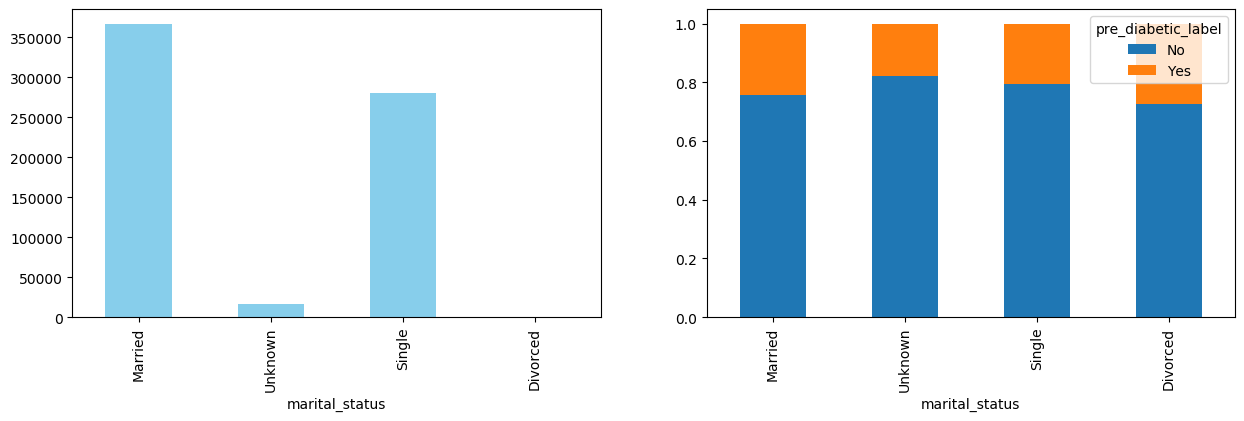

In [56]:
cat_vs_cat_plot('marital_status')

In [57]:
df.marital_status.value_counts()

Married     367212
Single      280830
Unknown      16443
Divorced        84
Name: marital_status, dtype: int64

In [58]:
active_list = ['ACTIVE','Active','Disability - Long Term or Perm','Disability - Short Term','LOA - Family Medical',
               'LOA - Military','LOA - no Pay','LOA - with Pay',"LOA - Worker's Compensation",'LOFF','LOA_NO_PAY',
              'LOA_FM', 'LOA_WITH_PAY','LTD','STD','LOA_WC','LOA_MLTR','LOA - Unpaid w/ Benefits','LOA - Paid Leave',
              'LOA - Unpaid Leave','LOA - STD','LOA - LTD','LOA - Workers Comp']
inactive_list = ['Inactive','COBRA Employee','Deceased - In Service','Deceased - Out-of-Service','Layoff','Retired',
                 'Severance Pay','Termination','RTEE','SVRN_PAY','DCSD_OUT_OF_SV','DCSD_INSV','COBRA_EE',
                'Terminated',]
non_employee_list = ['COBRA Dependent','Enrolled Beneficiary','Enrolled QDRO', 'ENRL_BENE','COBRA_DPND','ENRL_QDRO' ]
code_remove_list = ['DNM']

In [59]:
df.loc[df['mapped_employment_status_code'].isin(active_list), 'mapped_employment_status_code'] = 'Active'
df.loc[df['mapped_employment_status_code'].isin(inactive_list), 'mapped_employment_status_code'] = 'Inactive'
df.loc[df['mapped_employment_status_code'].isin(non_employee_list), 'mapped_employment_status_code'] = 'Non-Employee'
df.loc[df['mapped_employment_status_code'].isin(code_remove_list) == False]
df.loc[df['mapped_employment_status_code'].isnull(), 'mapped_employment_status_code'] = 'Unknown'

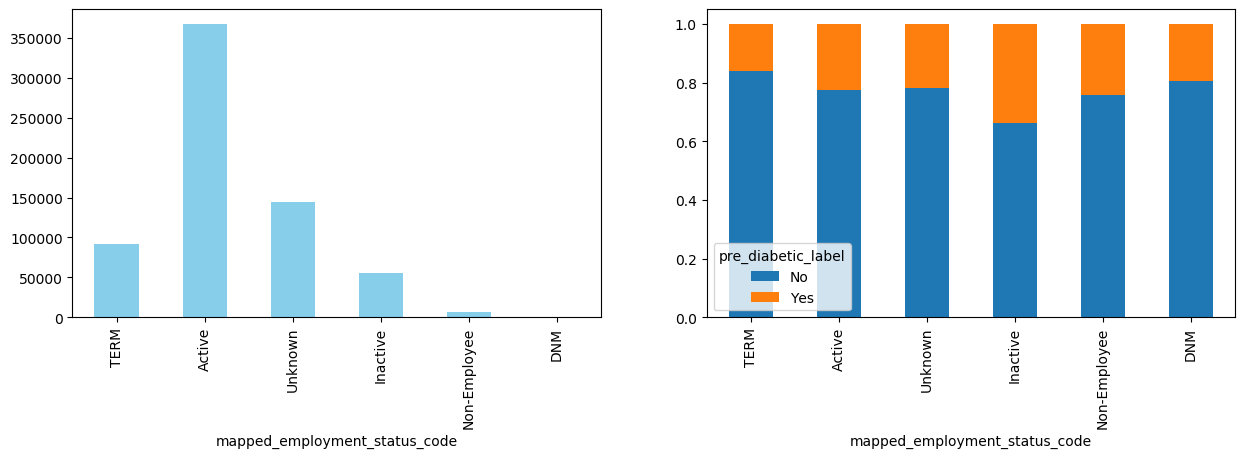

In [60]:
cat_vs_cat_plot('mapped_employment_status_code')

In [61]:
df.mapped_employment_status_code.value_counts()

Active          367400
Unknown         143859
TERM             91778
Inactive         55214
Non-Employee      6277
DNM                 41
Name: mapped_employment_status_code, dtype: int64

In [62]:
male = ['M', 'Male', 'male', 'Gender_Male']
female = ['F', 'Female', 'female', 'Gender_Female']
unknown = ['U', 'Unknown', 'Not_declared', 'D', 'Decline to answer', 'Undeclared',
           'Not specified', 'Declined to State','ND', 'N', 'O', 'Not Declared','X',
           'I do not wish to provide this information','Not declared','I Choose not to Disclose']

In [63]:
df.loc[df['gender'].isin(male), 'gender'] = 'Male'
df.loc[df['gender'].isin(female), 'gender'] = 'Female'
df.loc[df['gender'].isin(unknown), 'gender'] = 'Unknown'
df.loc[df['gender'].isnull(), 'gender'] = 'Unknown'

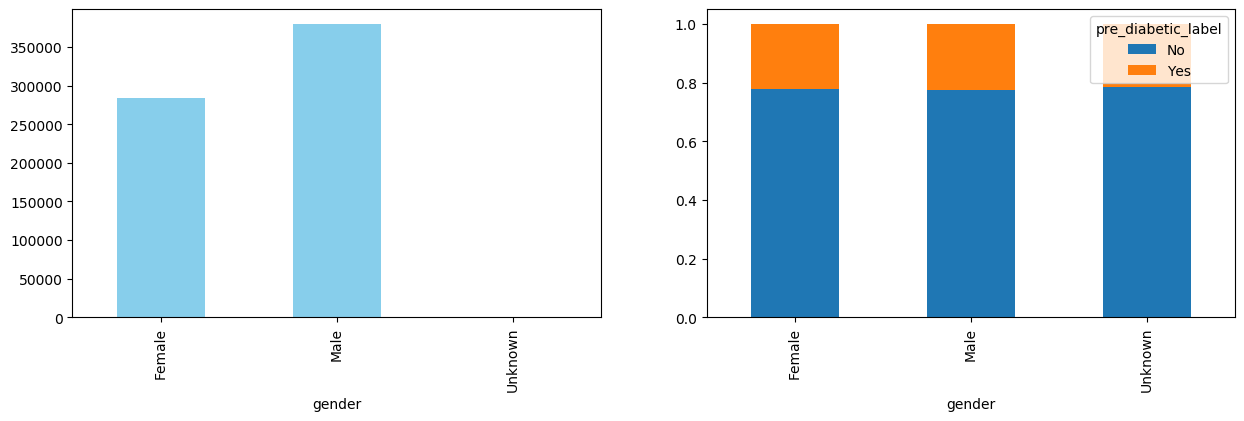

In [64]:
cat_vs_cat_plot('gender')

In [65]:
df.gender.value_counts()

Male       380124
Female     284009
Unknown       436
Name: gender, dtype: int64

In [66]:
df['mapped_flex_status_code'] = df['mapped_flex_status_code'].replace(['NOTELIGIBLE','ELIGIBLE'],['Not-Eligible', 'Eligible'])
flex_code_remove_list = ['DNM', 'INELIG', 'HIITSD', 'NGACT',
       'TSDACT', 'ACTIVE', 'LOALIF', 'NNSACT', 'ACTHER', 'RET', 'COBTSD',
       'ACTF', 'EXACT', 'SEVTSD']
df = df[df['mapped_flex_status_code'].isin(flex_code_remove_list) == False]
df.loc[df['mapped_flex_status_code'].isnull(), 'mapped_flex_status_code'] = 'Unknown'

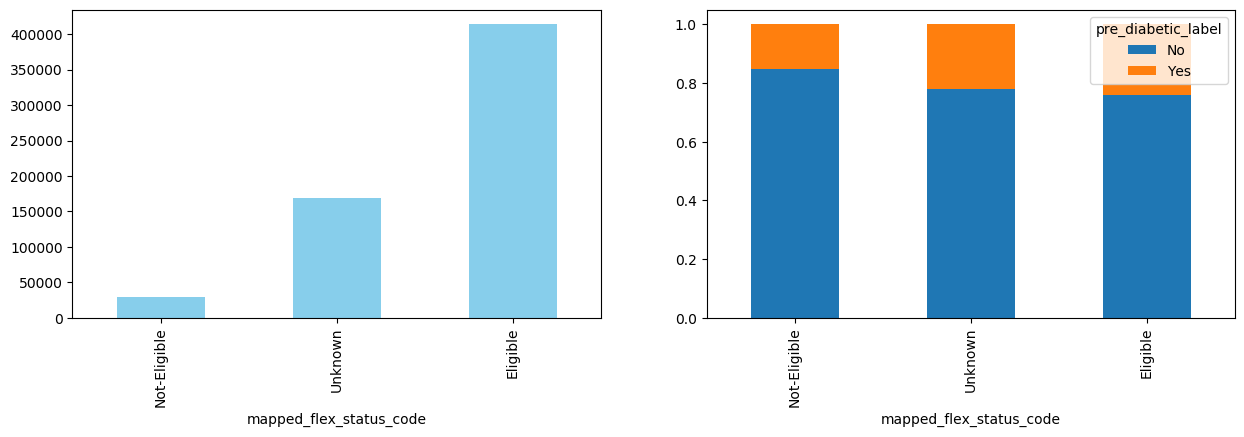

In [67]:
cat_vs_cat_plot('mapped_flex_status_code')

In [68]:
df.mapped_flex_status_code.value_counts()

Eligible        413704
Unknown         168595
Not-Eligible     29261
Name: mapped_flex_status_code, dtype: int64

In [69]:
df['base_pay_regular_frequency_code'] = df['base_pay_regular_frequency_code'].replace(['A1','H1','M1','W1','W2'],['Annual','Hourly','Monthly','Weekly','Weekly'])
pay_code_remove_list = ['1','2','3','4']
df = df[df['base_pay_regular_frequency_code'].isin(pay_code_remove_list) == False]
df.loc[df['base_pay_regular_frequency_code'].isnull(), 'base_pay_regular_frequency_code'] = 'Unknown'

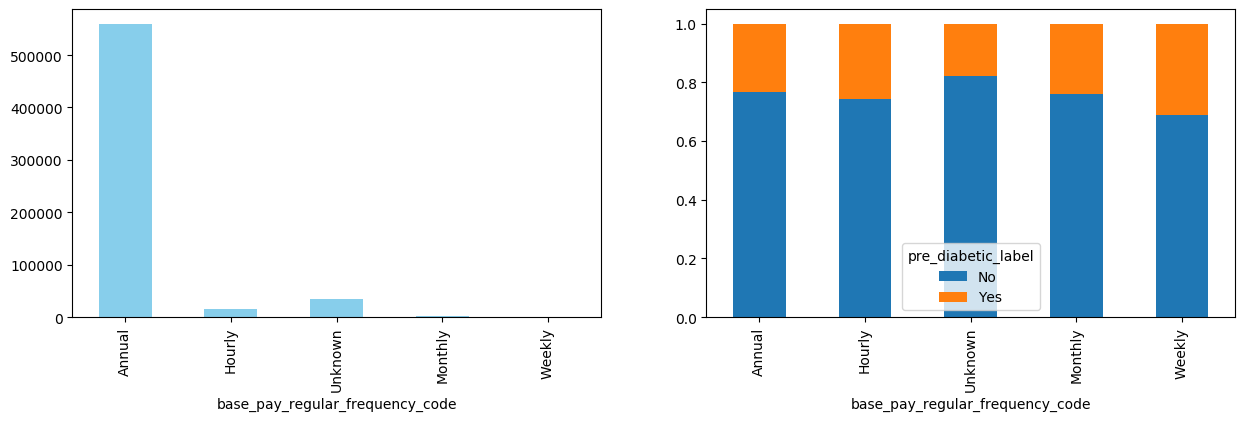

In [70]:
cat_vs_cat_plot('base_pay_regular_frequency_code')

In [71]:
df.base_pay_regular_frequency_code.value_counts()

Annual     559814
Unknown     34728
Hourly      14480
Monthly      2279
Weekly         42
Name: base_pay_regular_frequency_code, dtype: int64

Box-Plot and KDE for numeric data type-

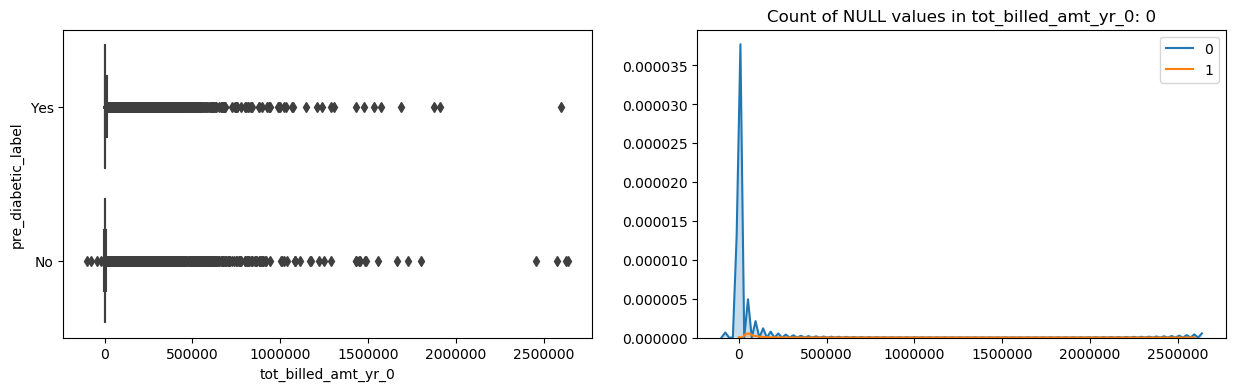

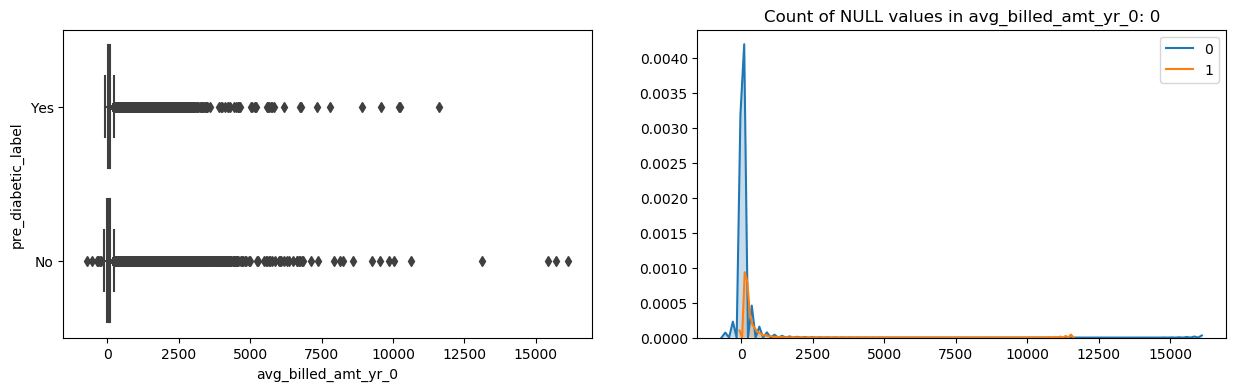

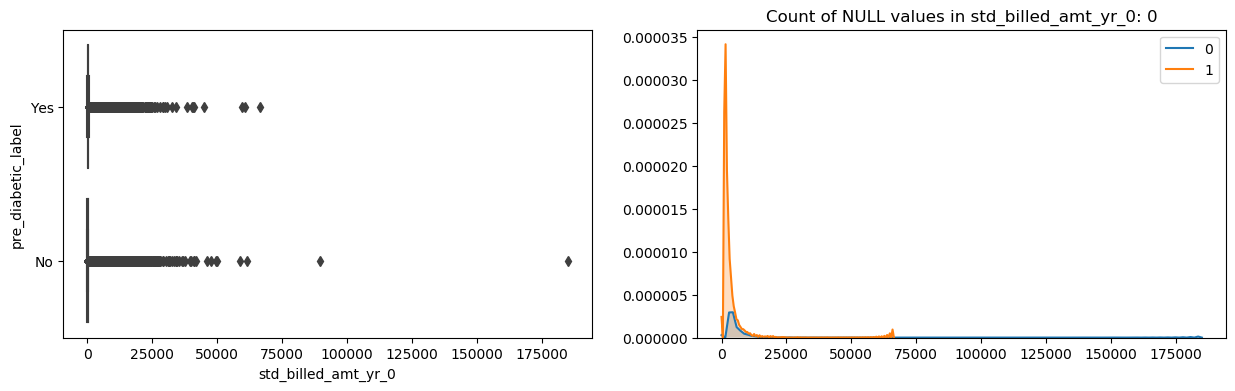

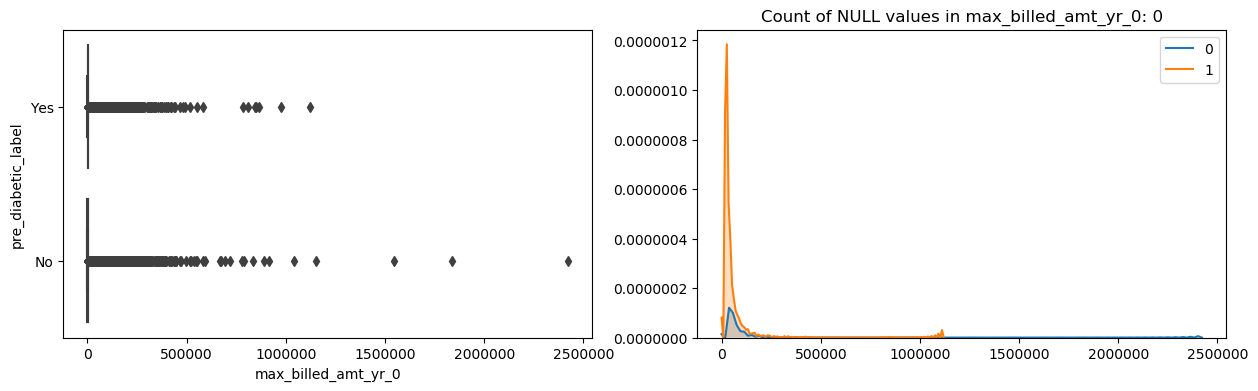

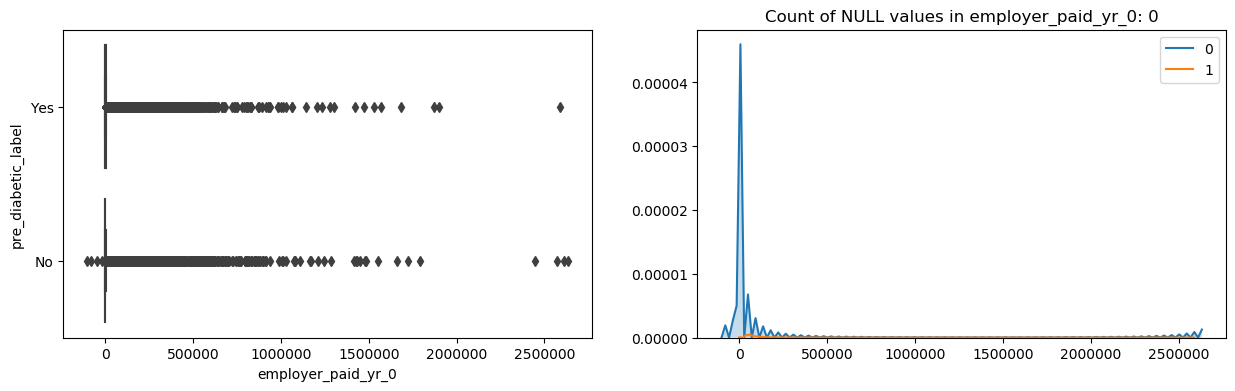

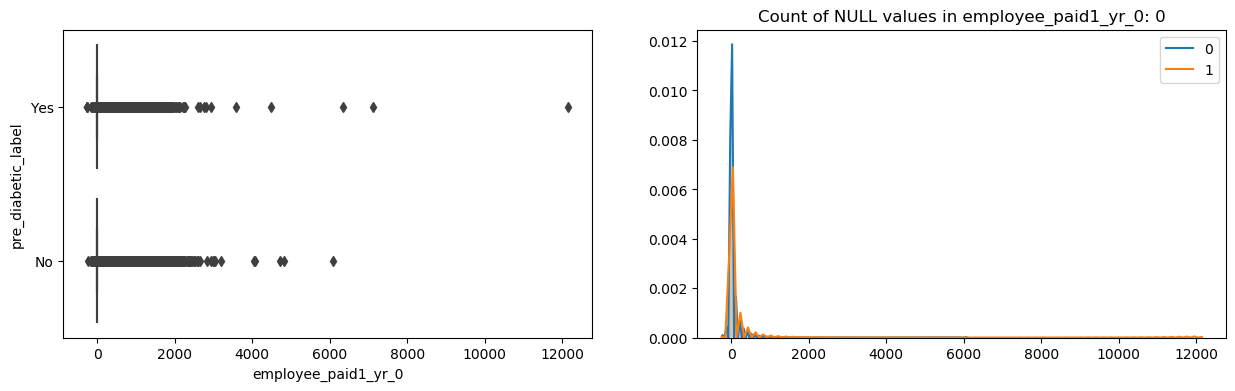

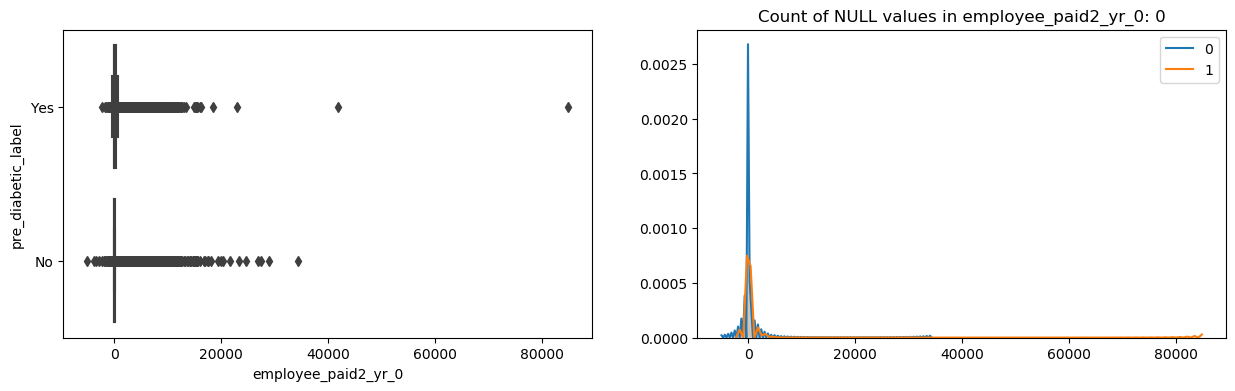

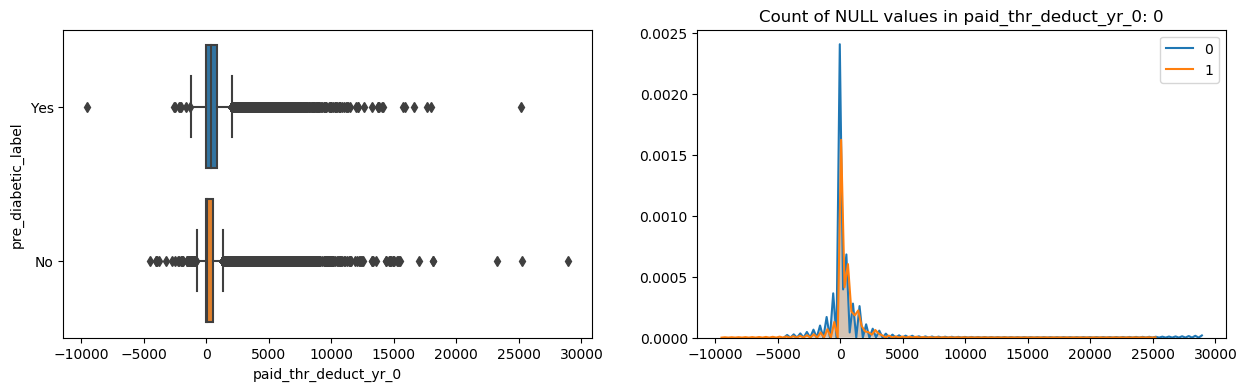

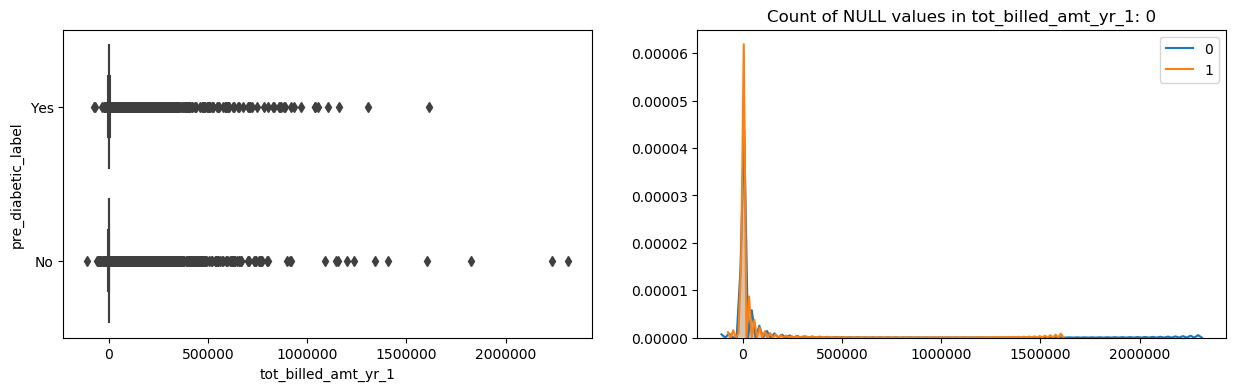

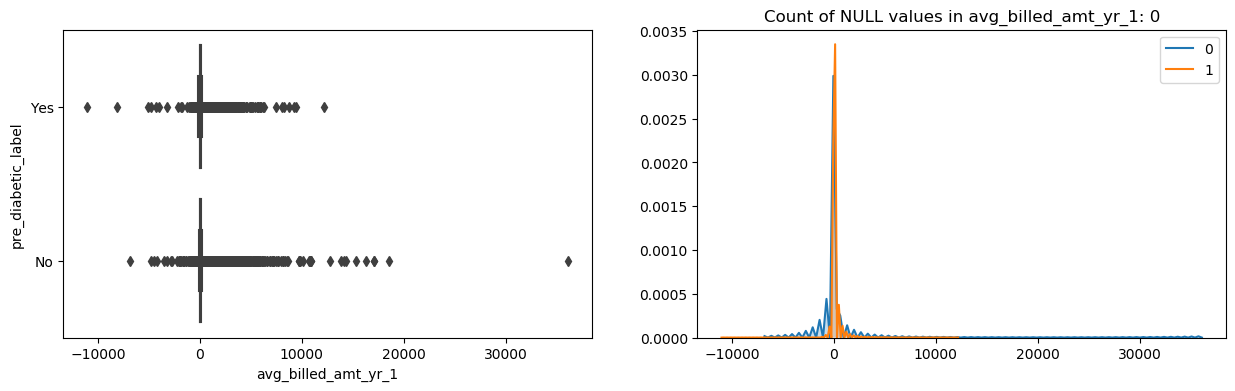

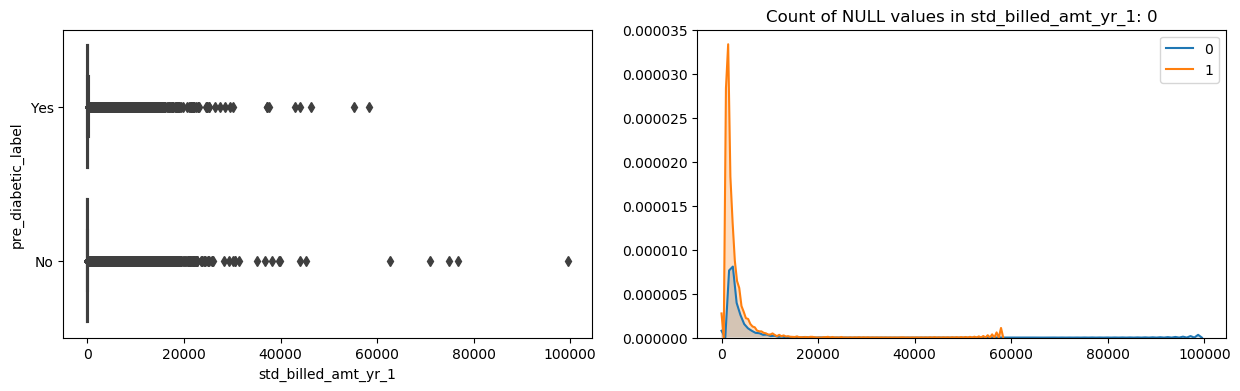

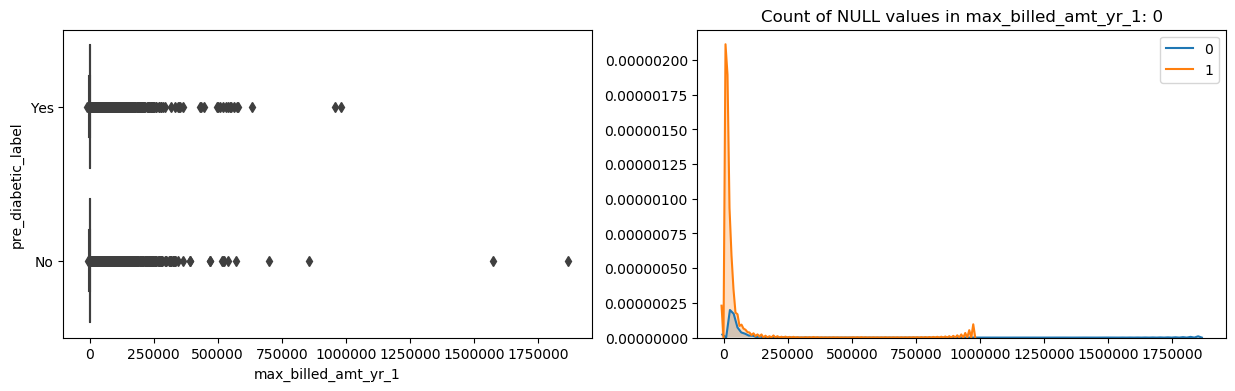

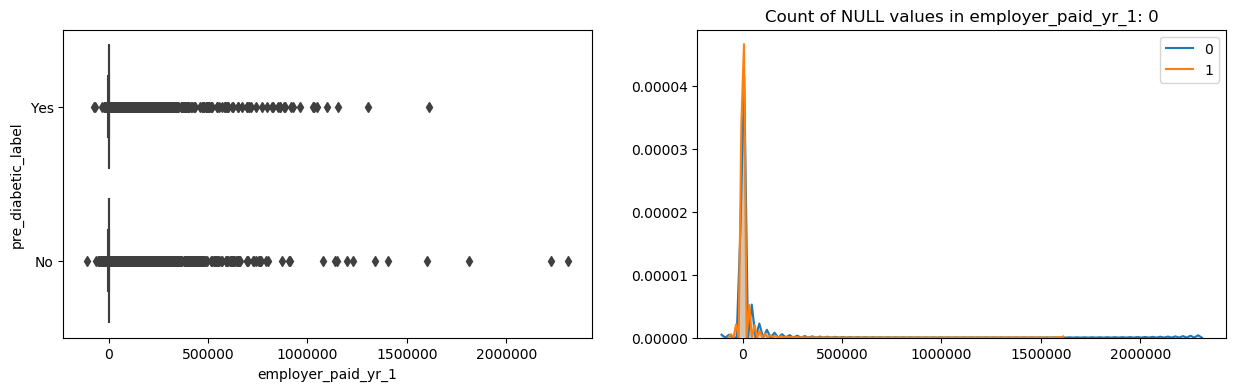

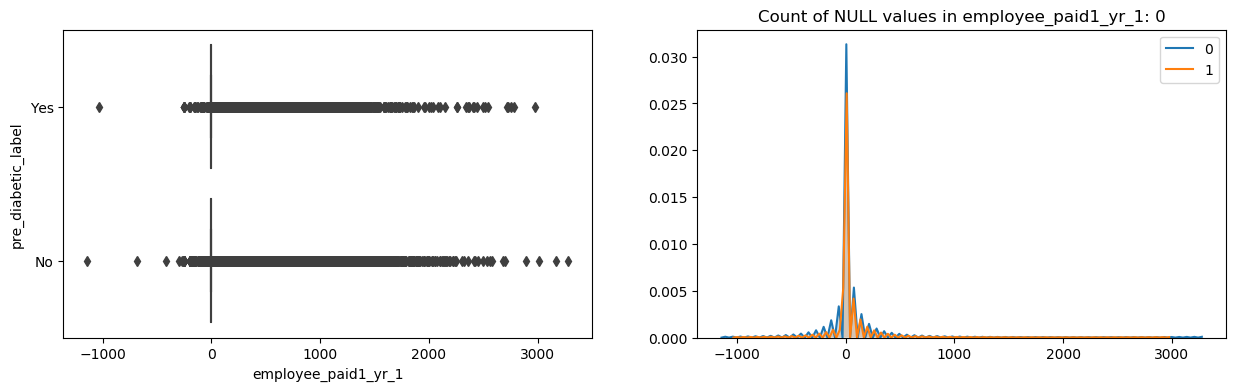

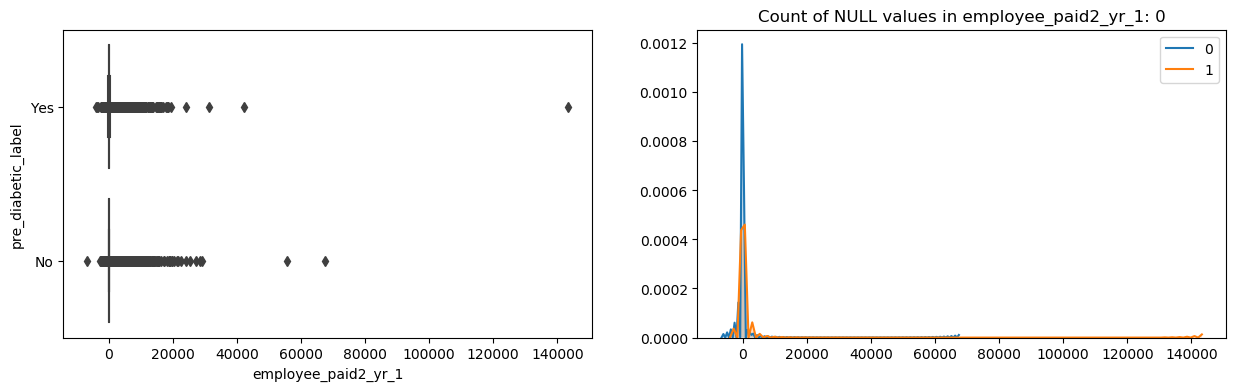

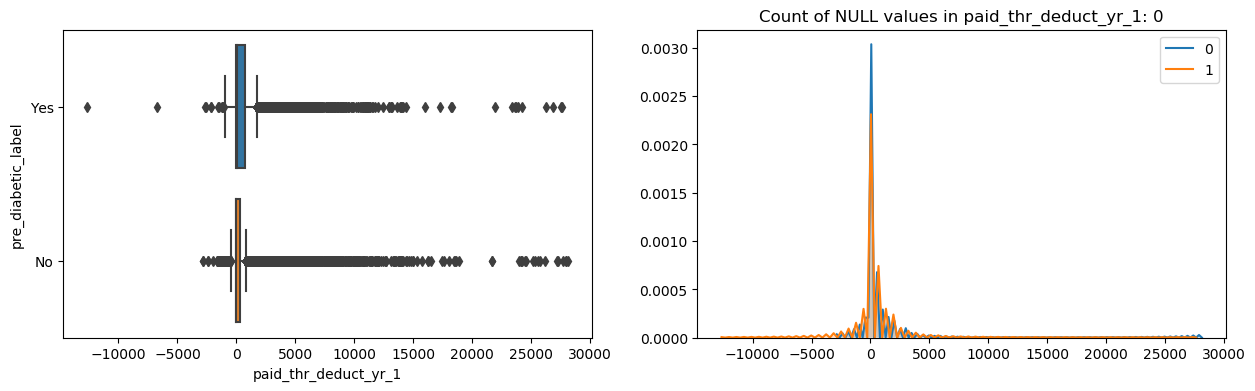

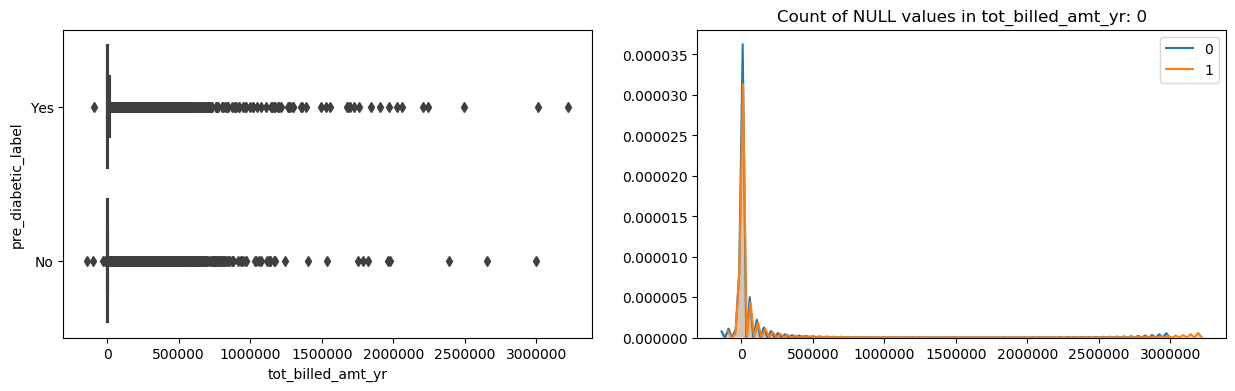

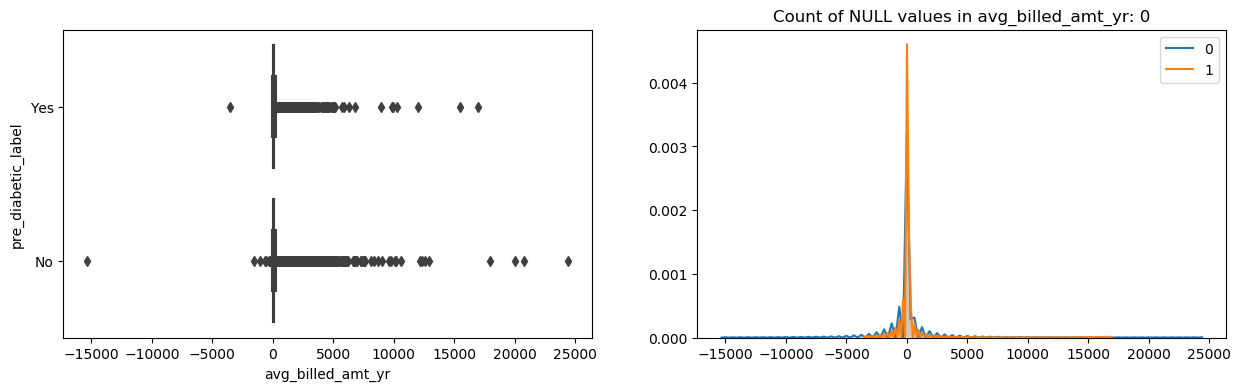

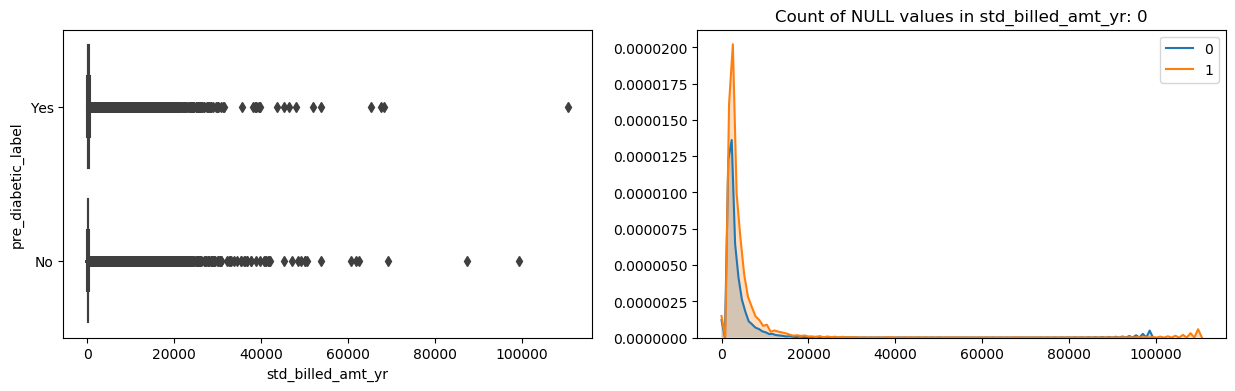

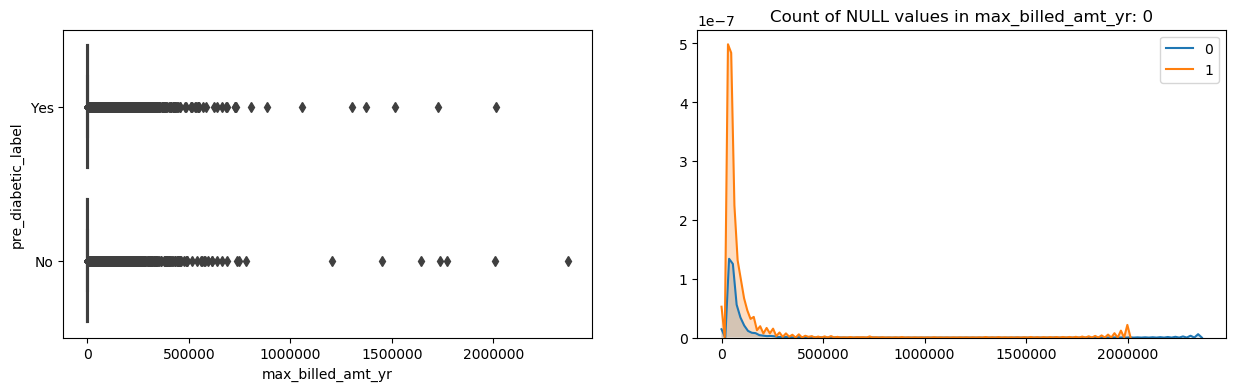

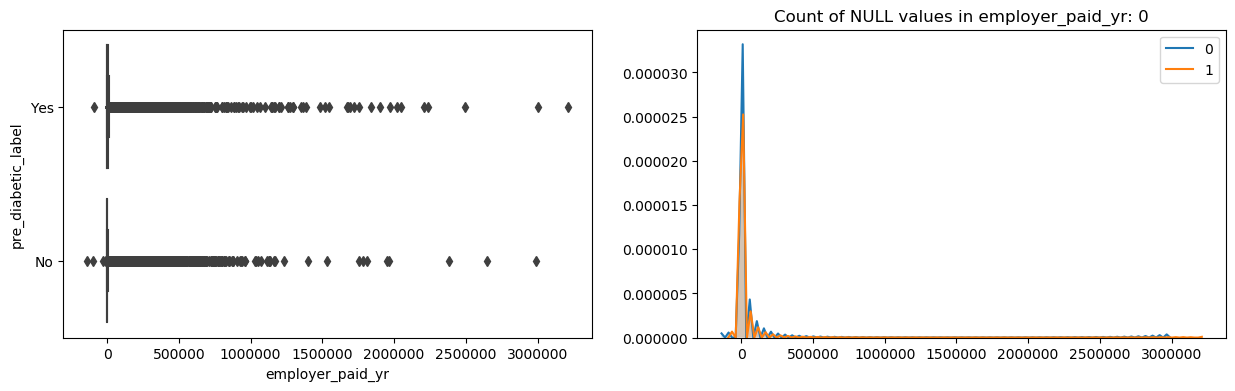

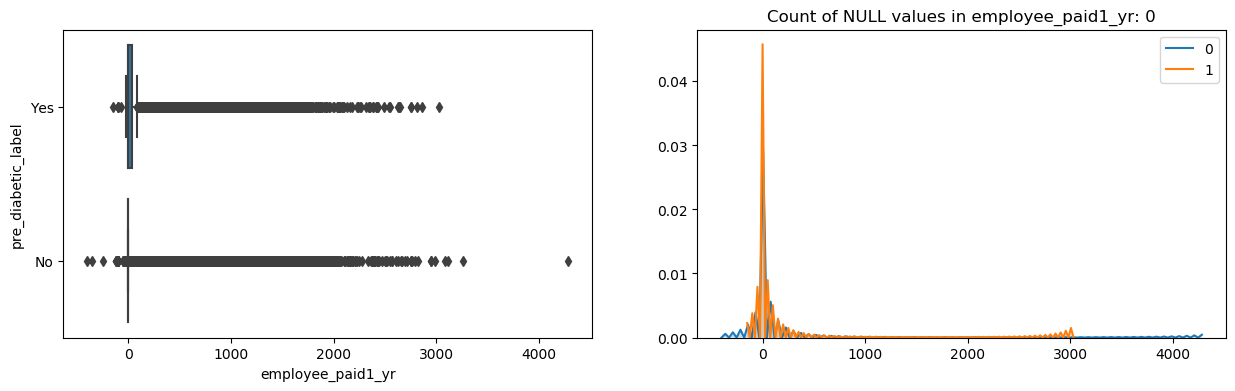

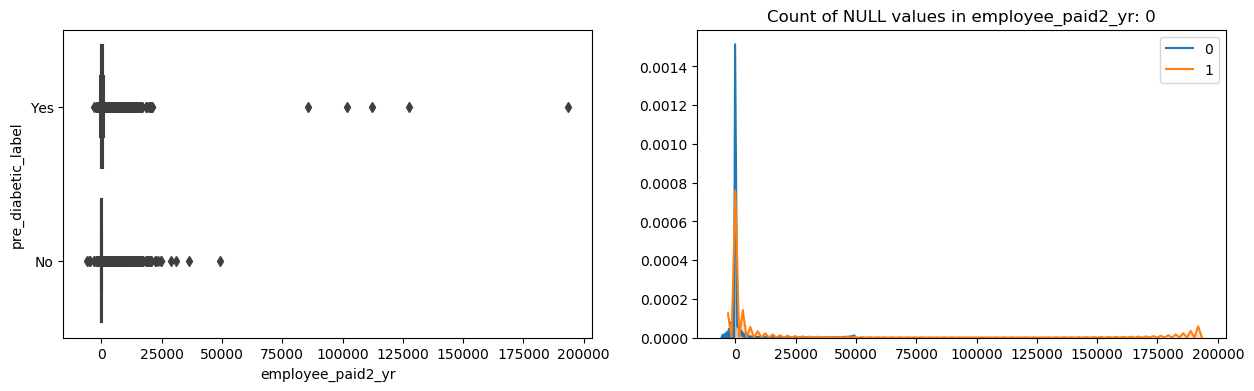

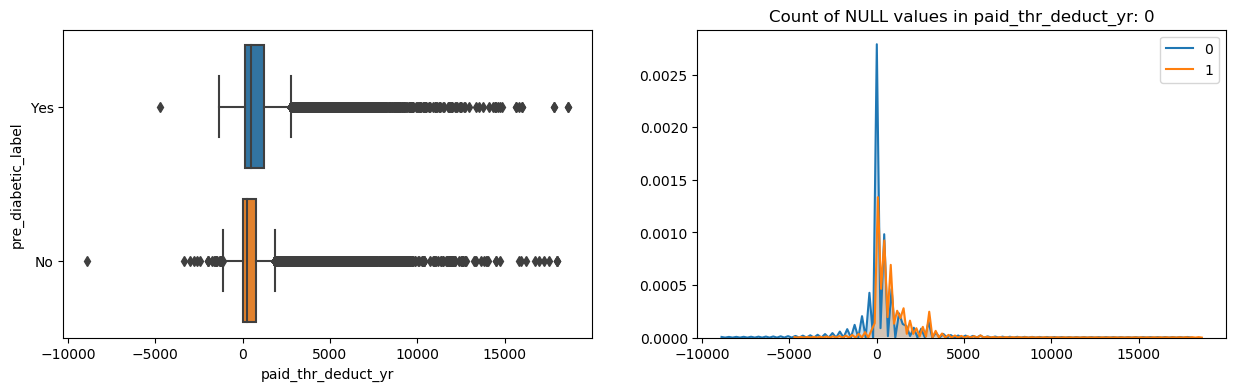

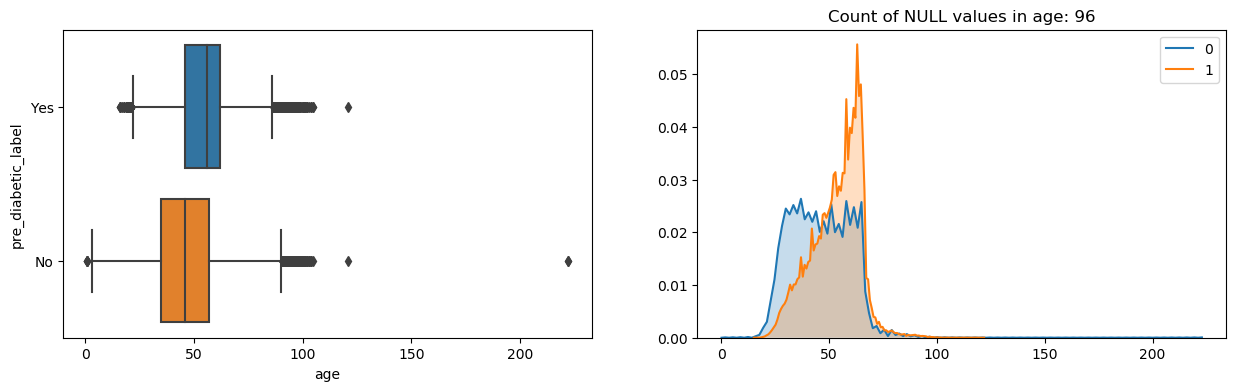

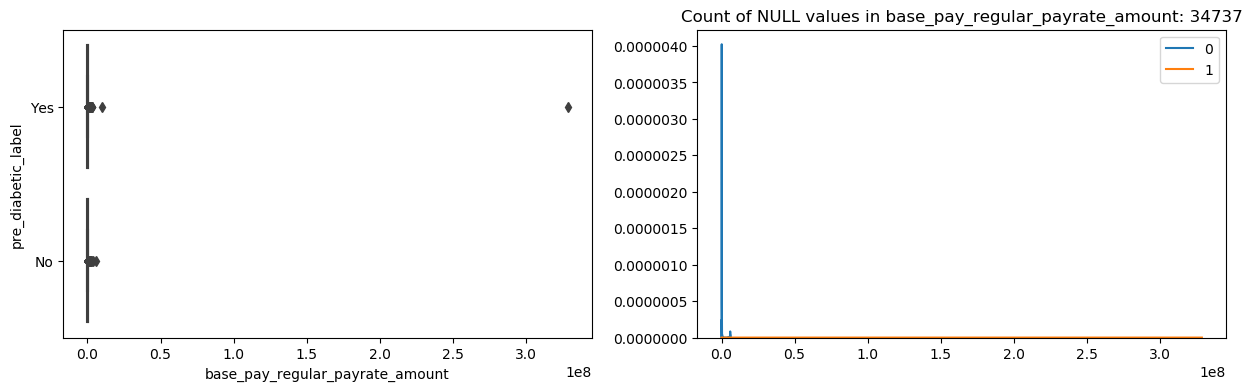

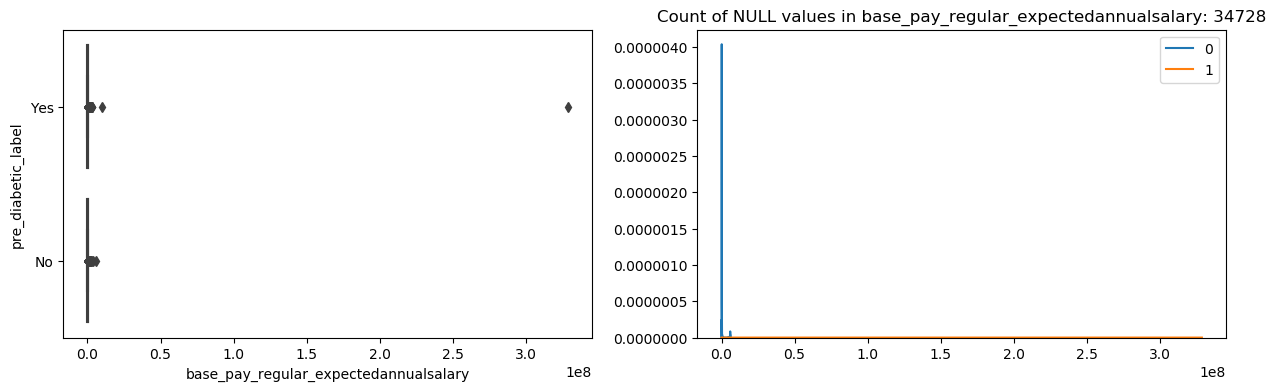

In [72]:
for i in (df.select_dtypes('float').columns):
    cat_vs_count_plot(i)

next step is to check multi-collinearity among predictors
using highly correlated features (among predictors) is not good for regression models. However, for treee based model
it is fine to use them, there is no impact.
Focus of this activity is to identify highly correlated features, and drop only variables having pearson correlation
equals to +- 1 (since mostly we will be using tree based algorithms only)

In [73]:
corr = df.corr().abs()

In [74]:
# setting diagonal entries as zero (from one) -- this to idenitfy highest correlation score for each feature
corr = corr.where(corr.values != np.diag(corr),0,corr.where(corr.values != np.flipud(corr).diagonal(0),0,inplace=True))

In [75]:
mult_corr_df = corr.max().round(3).sort_values(ascending=False).reset_index()
mult_corr_df.shape

(31, 2)

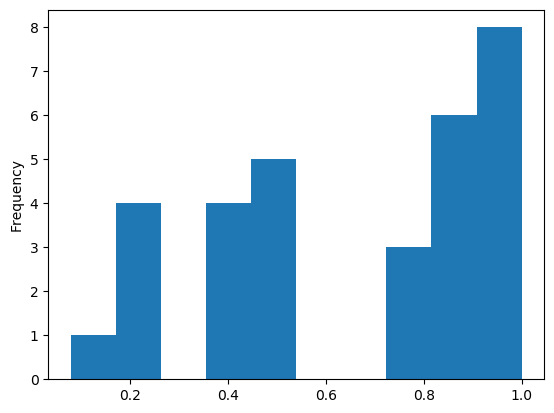

In [76]:
mult_corr_df[0].plot(kind='hist')

In [77]:
mult_corr_df.head(10)

,index,0
0,base_pay_regular_payrate_amount,1.000
1,base_pay_regular_expectedannualsalary,1.000
2,employer_paid_yr,0.998
3,tot_billed_amt_yr,0.998
4,tot_billed_amt_yr_0,0.997
5,employer_paid_yr_0,0.997
6,employer_paid_yr_1,0.996
7,tot_billed_amt_yr_1,0.996
8,std_billed_amt_yr_0,0.885
9,max_billed_amt_yr_0,0.885


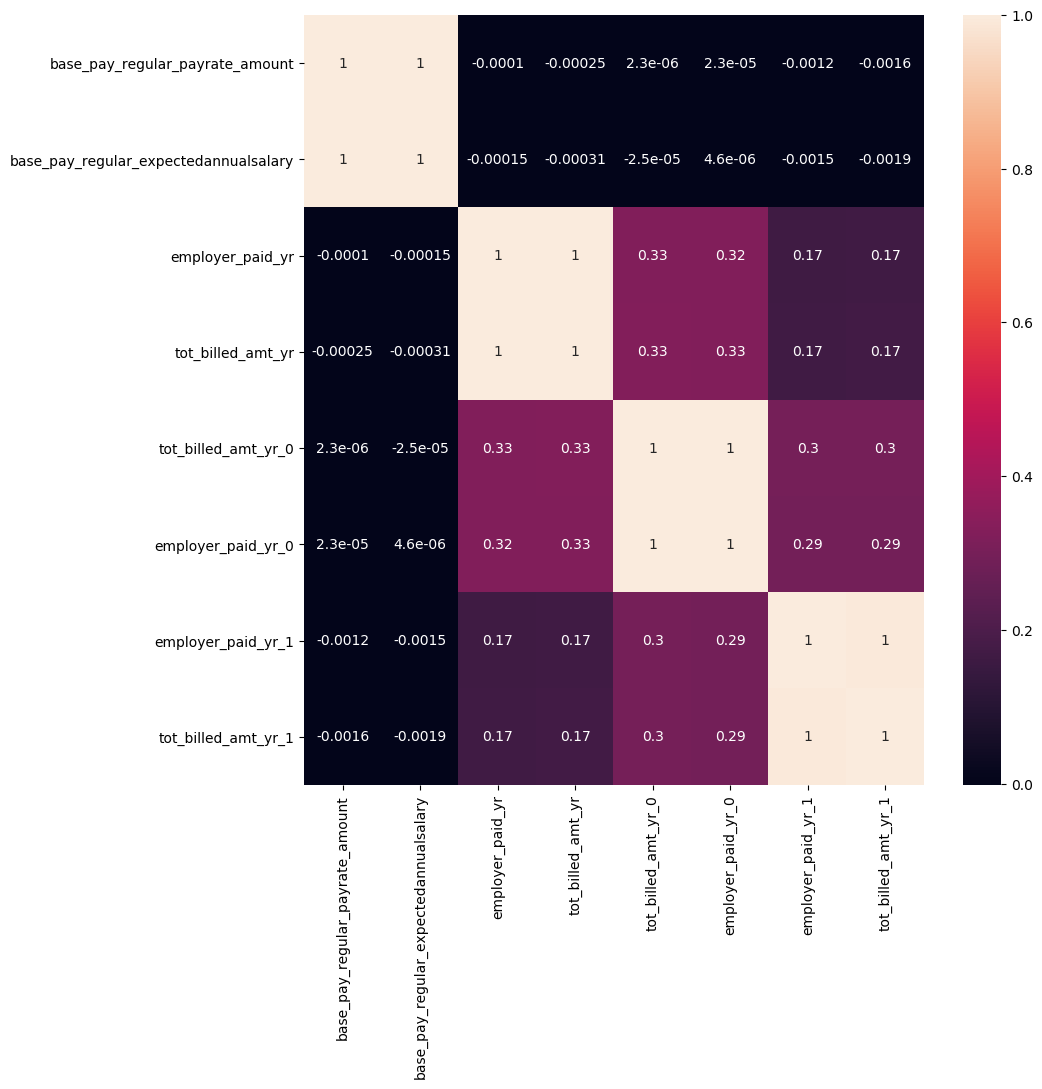

In [78]:
# let us look correlation matrix of variables with above score > 0.99
plt.figure(figsize=(10,10))
sns.heatmap(df[mult_corr_df[mult_corr_df[0]>0.99]['index'].tolist()].corr(), annot=True)
plt.show()

As we can observe that below groups are highly corelated
- Group1- annual_benefits_base_rate, base_pay_regular_expectedannualsalary, base_pay_regular_payrate_amount
- Group2- tot_billed_amt_yr_0, employer_paid_yr_0
- Group3- tot_billed_amt_yr_1, employer_paid_yr_1
- Group4- tot_billed_amt_yr, employer_paid_yr

we can consider only one variable from each group

In [79]:
mult_corr_list = mult_corr_df[mult_corr_df[0]>0.99]['index'].tolist()
mult_corr_list.append('target')
df[mult_corr_list].corr()['target'].sort_values(ascending=False)

target                                   1.000000
tot_billed_amt_yr                        0.084238
employer_paid_yr                         0.077376
tot_billed_amt_yr_1                      0.054190
tot_billed_amt_yr_0                      0.051918
employer_paid_yr_1                       0.048090
employer_paid_yr_0                       0.047013
base_pay_regular_expectedannualsalary   -0.002823
base_pay_regular_payrate_amount         -0.002971
Name: target, dtype: float64

In [80]:
# df.corr()['target'].sort_values(ascending=False)

In [81]:
# we can keep tot_billed_amt_yr_0, tot_billed_amt_yr_1 as these are highly correlated to
#keeping  base_pay_regular_expectedannualsalary as well
# target as compared to other variables
drop_list = ['employer_paid_yr_0','employer_paid_yr_1','base_pay_regular_payrate_amount']

In [82]:
# other vaiable we can drop which are not highly correlated with target variable to reduce dimentionalty of dataset

In [83]:
corr_with_target_df = corr['target'].abs().sort_values().round(3).reset_index()
corr_with_target_df.shape

(31, 2)

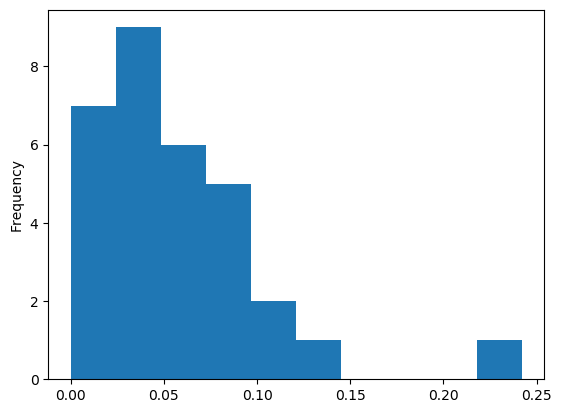

In [84]:
corr_with_target_df['target'].plot(kind='hist')

In [85]:
# variables which have less than 5% correlation with target variable
corr_with_target_df[corr_with_target_df['target']<0.05]

,index,target
0,person_internal_id,0.000
1,target,0.000
2,patient_key,0.002
3,base_pay_regular_expectedannualsalary,0.003
4,base_pay_regular_payrate_amount,0.003
5,client_id,0.008
6,avg_billed_amt_yr,0.018
7,avg_billed_amt_yr_0,0.034
8,employee_paid1_yr_1,0.034
9,employee_paid1_yr_0,0.037


In [86]:
cols_to_drop

82       mapped_high_compensation_description
81              mapped_high_compensation_code
87                            subsidiary_code
88                     subsidiary_description
73                      primary_language_code
92                                rehire_date
85                  mapped_hourly_salary_code
86           mapped_hourly_salary_description
100                 annual_benefits_base_rate
90             mapped_flex_status_description
84     mapped_permanent_temporary_description
83            mapped_permanent_temporary_code
80                mapped_fullpart_description
79                       mapped_fullpart_code
Name: column, dtype: object

In [87]:
#Drop unneccesray columns
drop_list.extend(['client_id','person_internal_id','patient_key','pre_diabetic_label','client_pid','udp_global_id', 
                  'state', 'client_pid','udp_global_id','is_union','is_rehire','base_pay_regular_frequency_description',
                  'mapped_employment_status_description','base_pay_regular_payrate_amount',
                  'country_description','termination_date','original_hire_date' ])

In [88]:
# df.columns

In [89]:
# drop_list

In [90]:
df.drop(columns = drop_list, axis=1,inplace=True)

In [91]:
df.shape

(611343, 71)

In [92]:
num_cols = [x for x in df.columns if ('amt' in x or 'paid' in x)] + ['age']

In [93]:
len(num_cols)

23

In [94]:
df[[x for x in df.columns if x not in num_cols]].head(2)

,screening_flag_yr_0,sleep_apnea_flag_yr_0,cushing_flag_yr_0,acromegaly_flag_yr_0,urinary_flag_yr_0,screening_flag_yr_1,sleep_apnea_flag_yr_1,cushing_flag_yr_1,acromegaly_flag_yr_1,urinary_flag_yr_1,screening_flag_yr,sleep_apnea_flag_yr,cushing_flag_yr,acromegaly_flag_yr,urinary_flag_yr,specialist_ind,primary_care_ind,inpatient_ind,physician_ind,outpatient_ind,unknown_ind,durable_medical_ind,lab_visit_ind,specialist_ind_y0,primary_care_ind_y0,inpatient_ind_y0,physician_ind_y0,outpatient_ind_y0,unknown_ind_y0,durable_medical_ind_y0,lab_visit_ind_y0,specialist_ind_y1,primary_care_ind_y1,inpatient_ind_y1,physician_ind_y1,outpatient_ind_y1,unknown_ind_y1,durable_medical_ind_y1,lab_visit_ind_y1,gender,marital_status,platform_indicator_code,mapped_employment_status_code,mapped_flex_status_code,base_pay_regular_frequency_code,base_pay_regular_expectedannualsalary,base_pay_regular_expectedannualsalary_range,target
0,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,Yes,No,No,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Female,Married,NaN,TERM,Not-Eligible,Annual,124866.82,"$100,000-$174,999",1
1,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,Male,Married,R3,Active,Unknown,Annual,70075.20,"$60,000-$79,999",0


In [95]:
df[num_cols].describe().round(0)

,tot_billed_amt_yr_0,avg_billed_amt_yr_0,std_billed_amt_yr_0,max_billed_amt_yr_0,employee_paid1_yr_0,employee_paid2_yr_0,paid_thr_deduct_yr_0,tot_billed_amt_yr_1,avg_billed_amt_yr_1,std_billed_amt_yr_1,max_billed_amt_yr_1,employee_paid1_yr_1,employee_paid2_yr_1,paid_thr_deduct_yr_1,tot_billed_amt_yr,avg_billed_amt_yr,std_billed_amt_yr,max_billed_amt_yr,employer_paid_yr,employee_paid1_yr,employee_paid2_yr,paid_thr_deduct_yr,age
count,611343.0,611343.0,611343.0,611343.0,611343.0,611343.0,611343.0,611343.0,611343.0,611343.0,611343.0,611343.0,611343.0,611343.0,611343.0,611343.0,611343.0,611343.0,611343.0,611343.0,611343.0,611343.0,611247.0
mean,5219.0,98.0,256.0,1885.0,36.0,269.0,487.0,3372.0,75.0,187.0,1273.0,24.0,205.0,374.0,6680.0,122.0,322.0,2415.0,5645.0,47.0,330.0,646.0,48.0
std,26030.0,195.0,973.0,11755.0,128.0,770.0,807.0,18420.0,209.0,805.0,8608.0,103.0,724.0,794.0,29878.0,217.0,1106.0,14312.0,29295.0,142.0,934.0,945.0,13.0
min,-98187.0,-689.0,0.0,-324.0,-250.0,-5035.0,-9495.0,-106465.0,-11018.0,0.0,-8129.0,-1140.0,-6636.0,-12634.0,-137912.0,-15324.0,0.0,-103.0,-137066.0,-400.0,-5786.0,-8884.0,1.0
25%,75.0,16.0,0.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,417.0,42.0,44.0,142.0,200.0,0.0,0.0,0.0,37.0
50%,720.0,55.0,57.0,183.0,0.0,0.0,158.0,172.0,27.0,25.0,98.0,0.0,0.0,0.0,1244.0,69.0,75.0,257.0,675.0,0.0,0.0,300.0,48.0
75%,2716.0,105.0,137.0,606.0,0.0,84.0,645.0,1416.0,81.0,91.0,318.0,0.0,11.0,439.0,3945.0,124.0,197.0,929.0,2601.0,10.0,165.0,812.0,59.0
max,2636617.0,16115.0,185128.0,2421475.0,12147.0,84841.0,28917.0,2313374.0,36087.0,99501.0,1865211.0,3276.0,143268.0,28117.0,3219357.0,24395.0,110551.0,2366361.0,3211107.0,4280.0,193419.0,18623.0,222.0


In [96]:
#we will drop rows with -ve values before modelling 
(df[num_cols]<0).sum()/df.shape[0]

tot_billed_amt_yr_0     0.000074
avg_billed_amt_yr_0     0.000074
std_billed_amt_yr_0     0.000000
max_billed_amt_yr_0     0.000005
employee_paid1_yr_0     0.000090
employee_paid2_yr_0     0.000370
paid_thr_deduct_yr_0    0.000379
tot_billed_amt_yr_1     0.002503
avg_billed_amt_yr_1     0.002503
std_billed_amt_yr_1     0.000000
max_billed_amt_yr_1     0.000147
employee_paid1_yr_1     0.000494
employee_paid2_yr_1     0.002241
paid_thr_deduct_yr_1    0.001377
tot_billed_amt_yr       0.000136
avg_billed_amt_yr       0.000136
std_billed_amt_yr       0.000000
max_billed_amt_yr       0.000003
employer_paid_yr        0.001282
employee_paid1_yr       0.000082
employee_paid2_yr       0.000285
paid_thr_deduct_yr      0.000399
age                     0.000000
dtype: float64

In [97]:
df.select_dtypes('object').columns

Index(['screening_flag_yr_0', 'sleep_apnea_flag_yr_0', 'cushing_flag_yr_0',
       'acromegaly_flag_yr_0', 'urinary_flag_yr_0', 'screening_flag_yr_1',
       'sleep_apnea_flag_yr_1', 'cushing_flag_yr_1', 'acromegaly_flag_yr_1',
       'urinary_flag_yr_1', 'screening_flag_yr', 'sleep_apnea_flag_yr',
       'cushing_flag_yr', 'acromegaly_flag_yr', 'urinary_flag_yr',
       'specialist_ind', 'primary_care_ind', 'inpatient_ind', 'physician_ind',
       'outpatient_ind', 'unknown_ind', 'durable_medical_ind', 'lab_visit_ind',
       'specialist_ind_y0', 'primary_care_ind_y0', 'inpatient_ind_y0',
       'physician_ind_y0', 'outpatient_ind_y0', 'unknown_ind_y0',
       'durable_medical_ind_y0', 'lab_visit_ind_y0', 'specialist_ind_y1',
       'primary_care_ind_y1', 'inpatient_ind_y1', 'physician_ind_y1',
       'outpatient_ind_y1', 'unknown_ind_y1', 'durable_medical_ind_y1',
       'lab_visit_ind_y1', 'gender', 'marital_status',
       'platform_indicator_code', 'mapped_employment_status_code',

In [98]:
# col_to_convert = ['screening_flag_yr_0', 'sleep_apnea_flag_yr_0', 'cushing_flag_yr_0',
#        'acromegaly_flag_yr_0', 'urinary_flag_yr_0', 'screening_flag_yr_1',
#        'sleep_apnea_flag_yr_1', 'cushing_flag_yr_1', 'acromegaly_flag_yr_1',
#        'urinary_flag_yr_1', 'screening_flag_yr', 'sleep_apnea_flag_yr',
#        'cushing_flag_yr', 'acromegaly_flag_yr', 'urinary_flag_yr',
#        'specialist_ind', 'primary_care_ind', 'inpatient_ind', 'physician_ind',
#        'outpatient_ind', 'unknown_ind', 'durable_medical_ind', 'lab_visit_ind',
#        'specialist_ind_y0', 'primary_care_ind_y0', 'inpatient_ind_y0',
#        'physician_ind_y0', 'outpatient_ind_y0', 'unknown_ind_y0',
#        'durable_medical_ind_y0', 'lab_visit_ind_y0', 'specialist_ind_y1',
#        'primary_care_ind_y1', 'inpatient_ind_y1', 'physician_ind_y1',
#        'outpatient_ind_y1', 'unknown_ind_y1', 'durable_medical_ind_y1',
#        'lab_visit_ind_y1']

In [99]:
# for i in col_to_convert:
#      df[i] = df[i].map({"Yes":1,"No":0})

In [100]:
# we are motly done with cleaning
# missing value imputation and capping in age column will be done after train-test spli
# We will drop rows with -ve values in numeric columns 

In [101]:
df.shape

(611343, 71)

In [102]:
df['target'].value_counts(normalize=True)

0    0.769074
1    0.230926
Name: target, dtype: float64

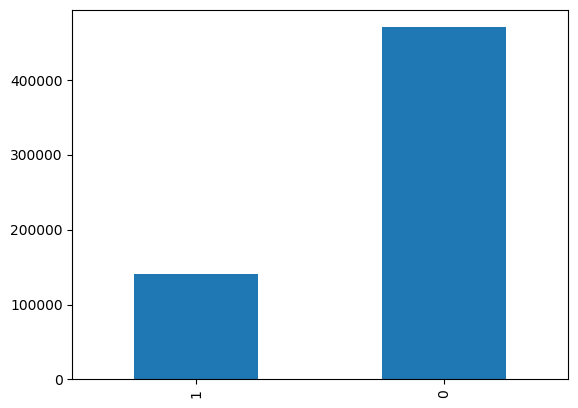

In [103]:
# target column
df["target"].value_counts().sort_values().plot(kind = 'bar')

Save preprocessed data:

In [104]:
print(f'Uploading pre-processed data here -> s3://{bucket}/{preprocessed_data}')
df.to_csv(f's3://{bucket}/{preprocessed_data}/preprocessed_data.csv', index=False)

Uploading pre-processed data here -> s3://adl-core-sagemaker-studio/external/artichauhan/Pre-Diabetes/Preprocessed-Data


Train-Test Split

In [105]:
#Split train-test data
from sklearn.model_selection import train_test_split

train_set,test_set = train_test_split(df, test_size = 0.20, 
                                   stratify=df['target'],shuffle=True, random_state=42)


In [106]:
print('train_set:',train_set.shape)
print('test_set:',test_set.shape)

train_set: (489074, 71)
test_set: (122269, 71)


In [107]:
x = train_set.groupby(['mapped_employment_status_code'])['age'].quantile([0.01, 0.99]).unstack()
capping=x.reset_index()
capping

,mapped_employment_status_code,0.01,0.99
0,Active,23.00,69.00
1,DNM,23.32,69.67
2,Inactive,33.00,90.00
3,Non-Employee,17.00,96.00
4,TERM,20.00,71.00
5,Unknown,22.00,80.00


In [108]:
train_set = train_set.merge(capping, how='left', on='mapped_employment_status_code')
train_set.shape

(489074, 73)

In [109]:
train_set.rename(columns={0.01:'lower_age_cap',0.99:'upper_age_cap'},inplace=True)

In [110]:
train_set[['age','lower_age_cap','upper_age_cap']]

,age,lower_age_cap,upper_age_cap
0,37.0,23.0,69.0
1,62.0,23.0,69.0
2,41.0,20.0,71.0
3,47.0,22.0,80.0
4,53.0,22.0,80.0
...,...,...,...
489069,41.0,22.0,80.0
489070,53.0,22.0,80.0
489071,47.0,23.0,69.0
489072,64.0,23.0,69.0


In [111]:
train_set['age'] = np.where(train_set['age'] > train_set['upper_age_cap'], train_set['upper_age_cap'], train_set['age'])

In [112]:
train_set['age'] = np.where(train_set['age'] < train_set['lower_age_cap'], train_set['lower_age_cap'], train_set['age'])

In [113]:
# drop newly creating columns
col=['lower_age_cap','upper_age_cap']
train_set.drop(columns=col,axis=1,inplace=True)

In [114]:
train_num_columns = train_set.select_dtypes(include=['int']).columns

#### Numeric Imputer for missing values

In [115]:
class CustomNumericImputer:
    
    def __init__(self):
        return None
    
    def fit(self, X, impute_cols, using_cols, method='median'):
        self.using_cols = using_cols
        self.impute_cols = impute_cols
        self.method = method
        cols = self.using_cols + self.impute_cols
        X_ = X[cols]
        
        if self.method == 'median':
            self.fit_values = X_.groupby(using_cols)[impute_cols].median().reset_index()
            impute_cols_rename_dict = dict([(x,x+'_median') for x in self.impute_cols])
            self.fit_values.rename(columns=impute_cols_rename_dict, inplace=True)
            self.fit_values.fillna(self.fit_values.median(), inplace=True)
        elif self.method == 'mean':
            self.fit_values = X_.groupby(using_cols)[impute_cols].mean().reset_index()
            impute_cols_rename_dict = dict([(x,x+'_mean') for x in self.impute_cols])
            self.fit_values.rename(columns=impute_cols_rename_dict, inplace=True)
            self.fit_values.fillna(self.fit_values.mean(), inplace=True)
        else: print('Method can be "median" or "mean"')
        self.new_cols = list(impute_cols_rename_dict.values())
        return self
    
    def fit_transform(self, X, impute_cols, using_cols, method='median'):
        self.fit(X, impute_cols, using_cols, method)
        
        cols = self.using_cols + self.impute_cols
        X_ = X[cols]
        X_ = X_.merge(self.fit_values, how='left', on=self.using_cols)
        for col, ncol in zip(self.impute_cols, self.new_cols):
            X_[col] = np.where(X_[col].isnull(), X_[ncol], X_[col])
            
        if self.method == 'median':
            return X_[self.impute_cols].fillna(X_[self.impute_cols].median())
        elif self.method == 'mean':
            return X_[self.impute_cols].fillna(X_[self.impute_cols].mean())
    
    def transform(self, X, impute_cols):
        cols = self.using_cols + self.impute_cols
        X_ = X[cols]
        X_ = X_.merge(self.fit_values, how='left', on=self.using_cols)
        for col, ncol in zip(self.impute_cols,self.new_cols):
            X_[col] = np.where(X_[col].isnull(), X_[ncol], X_[col])
            
        if self.method == 'median':
            return X_[self.impute_cols].fillna(X_[self.impute_cols].median())
        elif self.method == 'mean':
            return X_[self.impute_cols].fillna(X_[self.impute_cols].mean())
         

In [116]:
custom_numeric_imputer = CustomNumericImputer()

In [117]:
train_set[train_num_columns].describe()

,target
count,489074.000000
mean,0.230926
std,0.421426
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [118]:
train_float_columns = train_set.select_dtypes(include=['float']).columns

In [119]:
train_set[train_float_columns].describe()

,tot_billed_amt_yr_0,avg_billed_amt_yr_0,std_billed_amt_yr_0,max_billed_amt_yr_0,employee_paid1_yr_0,employee_paid2_yr_0,paid_thr_deduct_yr_0,tot_billed_amt_yr_1,avg_billed_amt_yr_1,std_billed_amt_yr_1,max_billed_amt_yr_1,employee_paid1_yr_1,employee_paid2_yr_1,paid_thr_deduct_yr_1,tot_billed_amt_yr,avg_billed_amt_yr,std_billed_amt_yr,max_billed_amt_yr,employer_paid_yr,employee_paid1_yr,employee_paid2_yr,paid_thr_deduct_yr,age,base_pay_regular_expectedannualsalary
count,4.890740e+05,489074.000000,489074.000000,4.890740e+05,489074.000000,489074.000000,489074.000000,4.890740e+05,489074.000000,489074.000000,4.890740e+05,489074.000000,489074.000000,489074.000000,4.890740e+05,489074.000000,489074.000000,4.890740e+05,4.890740e+05,489074.000000,489074.000000,489074.000000,489002.000000,4.612800e+05
mean,5.241183e+03,98.348553,256.272311,1.892821e+03,36.373221,269.394435,487.094936,3.374358e+03,74.923640,187.765954,1.273752e+03,23.985706,205.652297,375.259971,6.708720e+03,122.182106,322.336728,2.418385e+03,5.673171e+03,46.842087,331.088823,645.380329,47.785044,9.332214e+04
std,2.615263e+04,195.826023,975.423452,1.174467e+04,127.347650,766.167004,804.277952,1.835972e+04,210.888475,805.528345,8.437684e+03,103.608472,729.432836,795.838856,3.023249e+04,218.559447,1100.311323,1.420339e+04,2.965464e+04,141.675283,899.840391,943.751033,13.207733,4.880005e+05
min,-9.818706e+04,-362.313875,0.000000,-3.240900e+02,-250.000000,-5034.520000,-9494.720000,-1.064651e+05,-11018.395000,0.000000,-4.780290e+03,-1140.000000,-4000.000000,-12633.880000,-1.379117e+05,-15323.518889,0.000000,-1.027400e+02,-1.370656e+05,-360.000000,-5786.460000,-8884.410000,17.000000,0.000000e+00
25%,7.600000e+01,15.690631,0.000000,4.900000e+01,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,4.167825e+02,41.731906,43.651285,1.415800e+02,1.997925e+02,0.000000,0.000000,0.000000,37.000000,4.875480e+04
50%,7.224950e+02,54.908905,56.660406,1.837150e+02,0.000000,0.000000,158.430000,1.730500e+02,27.057413,25.568354,9.821000e+01,0.000000,0.000000,0.000000,1.243105e+03,68.820000,75.379161,2.567400e+02,6.756000e+02,0.000000,0.000000,300.000000,48.000000,8.334560e+04
75%,2.723755e+03,105.522375,137.592809,6.095675e+02,0.000000,85.000000,644.007500,1.417730e+03,80.530000,90.703907,3.187200e+02,0.000000,10.720000,440.860000,3.957367e+03,124.605441,197.589271,9.320775e+02,2.612998e+03,10.000000,166.230000,812.157500,59.000000,1.206833e+05
max,2.636617e+06,16115.461667,185127.707935,2.421475e+06,6354.630000,41867.750000,28917.340000,2.233568e+06,36086.847500,99500.841376,1.865211e+06,3170.000000,143267.510000,27963.220000,3.219357e+06,24394.582500,110551.046644,2.015073e+06,3.211107e+06,4279.600000,127635.790000,18623.100000,96.000000,3.285675e+08


In [120]:
train_set[train_float_columns] = custom_numeric_imputer.fit_transform(X=train_set, impute_cols=train_float_columns.tolist(),
                                                              using_cols=['mapped_employment_status_code'], method='median')

In [121]:
custom_numeric_imputer.fit_values

,mapped_employment_status_code,tot_billed_amt_yr_0_median,avg_billed_amt_yr_0_median,std_billed_amt_yr_0_median,max_billed_amt_yr_0_median,employee_paid1_yr_0_median,employee_paid2_yr_0_median,paid_thr_deduct_yr_0_median,tot_billed_amt_yr_1_median,avg_billed_amt_yr_1_median,std_billed_amt_yr_1_median,max_billed_amt_yr_1_median,employee_paid1_yr_1_median,employee_paid2_yr_1_median,paid_thr_deduct_yr_1_median,tot_billed_amt_yr_median,avg_billed_amt_yr_median,std_billed_amt_yr_median,max_billed_amt_yr_median,employer_paid_yr_median,employee_paid1_yr_median,employee_paid2_yr_median,paid_thr_deduct_yr_median,age_median,base_pay_regular_expectedannualsalary_median
0,Active,737.090,56.900000,58.036793,188.660,0.0,0.0,170.570,181.21,28.237500,26.967548,101.020,0.0,0.0,0.00,1286.110,69.209259,76.460939,262.55,714.36,0.0,0.0,300.000,48.0,88258.00
1,DNM,1771.995,69.453500,94.334128,247.705,50.0,0.0,0.000,1428.76,62.771838,63.969885,207.415,40.0,0.0,0.00,1718.525,63.300562,82.144873,253.19,1064.41,60.0,0.0,36.865,58.5,110000.02
2,Inactive,1345.970,61.578462,72.204226,254.000,0.0,0.0,367.680,669.84,45.465278,53.736849,174.910,0.0,0.0,133.75,1712.260,68.268537,83.358098,311.29,876.55,0.0,0.0,400.000,64.0,86680.00
3,Non-Employee,1182.420,58.865484,64.826778,225.670,0.0,0.0,206.390,405.53,39.414286,44.681431,142.490,0.0,0.0,0.00,1467.090,64.222308,74.295217,264.81,818.31,0.0,0.0,298.970,62.0,76765.60
4,TERM,543.600,49.685625,50.049341,160.000,0.0,0.0,102.820,1.03,0.280000,0.000000,11.450,0.0,0.0,0.00,850.550,66.535263,66.712242,212.57,426.67,0.0,0.0,222.600,38.0,48754.80
5,Unknown,593.350,49.896667,51.540626,166.485,0.0,0.0,84.155,102.67,19.814000,3.288047,70.265,0.0,0.0,0.00,1236.715,69.533143,75.655431,256.05,686.31,0.0,0.0,283.110,47.0,80868.27


In [122]:
# creating bins on the column base_pay_regular_expectedannualsalary and converting it into a range
bins = [-1, 19999, 39999, 59999, 79999, 99999, 174999,249999, 999999999999]
labels = ['<20,000', '20,000 - 39,999', '40,000 - 59,999', '60,000 - 79,999', '80,000 - 99,999', '100,000-174999', '175000-249999', '>250000']
train_set['base_pay_regular_expected_annual_salary_range'] = pd.cut(x=train_set['base_pay_regular_expectedannualsalary'], bins=bins, labels=labels)

In [123]:
# train_set.info()

In [124]:
#Let's drop some columns which are not required
col = ['base_pay_regular_expectedannualsalary','base_pay_regular_expectedannualsalary_range']
train_set.drop(columns=col,axis=1,inplace=True)

In [125]:
train_set.shape

(489074, 70)

In [126]:
train_set['age'] =train_set['age'].astype('int')

In [127]:
train_set['base_pay_regular_expected_annual_salary_range'] =train_set['base_pay_regular_expected_annual_salary_range'].astype('object')

In [128]:
for col in num_cols:
    train_set[col] = np.where(train_set[col]<0, np.nan, train_set[col])

In [129]:
train_set[num_cols].isna().sum()/train_set.shape[0]

tot_billed_amt_yr_0     0.000063
avg_billed_amt_yr_0     0.000063
std_billed_amt_yr_0     0.000000
max_billed_amt_yr_0     0.000004
employee_paid1_yr_0     0.000086
employee_paid2_yr_0     0.000382
paid_thr_deduct_yr_0    0.000397
tot_billed_amt_yr_1     0.002499
avg_billed_amt_yr_1     0.002499
std_billed_amt_yr_1     0.000000
max_billed_amt_yr_1     0.000141
employee_paid1_yr_1     0.000493
employee_paid2_yr_1     0.002212
paid_thr_deduct_yr_1    0.001394
tot_billed_amt_yr       0.000123
avg_billed_amt_yr       0.000123
std_billed_amt_yr       0.000000
max_billed_amt_yr       0.000004
employer_paid_yr        0.001290
employee_paid1_yr       0.000086
employee_paid2_yr       0.000288
paid_thr_deduct_yr      0.000413
age                     0.000000
dtype: float64

In [130]:
train_set.dropna().shape[0]/train_set.shape[0]

0.9342308116972073

In [131]:
train_set.dropna(inplace=True)
train_set.shape

(456908, 70)

In [132]:
train_set.isna().sum().sum()

0

In [133]:
train_cat_columns = train_set.select_dtypes(include=['object']).columns

In [134]:
print(train_cat_columns)
print(train_num_columns)
print(train_float_columns)

Index(['screening_flag_yr_0', 'sleep_apnea_flag_yr_0', 'cushing_flag_yr_0',
       'acromegaly_flag_yr_0', 'urinary_flag_yr_0', 'screening_flag_yr_1',
       'sleep_apnea_flag_yr_1', 'cushing_flag_yr_1', 'acromegaly_flag_yr_1',
       'urinary_flag_yr_1', 'screening_flag_yr', 'sleep_apnea_flag_yr',
       'cushing_flag_yr', 'acromegaly_flag_yr', 'urinary_flag_yr',
       'specialist_ind', 'primary_care_ind', 'inpatient_ind', 'physician_ind',
       'outpatient_ind', 'unknown_ind', 'durable_medical_ind', 'lab_visit_ind',
       'specialist_ind_y0', 'primary_care_ind_y0', 'inpatient_ind_y0',
       'physician_ind_y0', 'outpatient_ind_y0', 'unknown_ind_y0',
       'durable_medical_ind_y0', 'lab_visit_ind_y0', 'specialist_ind_y1',
       'primary_care_ind_y1', 'inpatient_ind_y1', 'physician_ind_y1',
       'outpatient_ind_y1', 'unknown_ind_y1', 'durable_medical_ind_y1',
       'lab_visit_ind_y1', 'gender', 'marital_status',
       'platform_indicator_code', 'mapped_employment_status_code',

In [135]:
pd.get_dummies(data=train_set, columns=train_cat_columns, drop_first=True).shape

(456908, 81)

In [136]:
train_set = pd.get_dummies(data=train_set, columns=train_cat_columns, drop_first=True)
train_set.shape

(456908, 81)

In [137]:
train_set.isna().sum().sum()

0

In [138]:
train_set.head(2)

,tot_billed_amt_yr_0,avg_billed_amt_yr_0,std_billed_amt_yr_0,max_billed_amt_yr_0,employee_paid1_yr_0,employee_paid2_yr_0,paid_thr_deduct_yr_0,tot_billed_amt_yr_1,avg_billed_amt_yr_1,std_billed_amt_yr_1,max_billed_amt_yr_1,employee_paid1_yr_1,employee_paid2_yr_1,paid_thr_deduct_yr_1,tot_billed_amt_yr,avg_billed_amt_yr,std_billed_amt_yr,max_billed_amt_yr,employer_paid_yr,employee_paid1_yr,employee_paid2_yr,paid_thr_deduct_yr,age,target,cushing_flag_yr_0_Yes,acromegaly_flag_yr_0_Yes,urinary_flag_yr_0_Yes,cushing_flag_yr_1_Yes,acromegaly_flag_yr_1_Yes,urinary_flag_yr_1_Yes,cushing_flag_yr_Yes,acromegaly_flag_yr_Yes,urinary_flag_yr_Yes,specialist_ind_Yes,primary_care_ind_Yes,inpatient_ind_Yes,physician_ind_Yes,outpatient_ind_Yes,unknown_ind_Yes,durable_medical_ind_Yes,lab_visit_ind_Yes,specialist_ind_y0_Yes,primary_care_ind_y0_Yes,physician_ind_y0_Yes,unknown_ind_y0_Yes,durable_medical_ind_y0_Yes,lab_visit_ind_y0_Yes,specialist_ind_y1_Yes,primary_care_ind_y1_Yes,physician_ind_y1_Yes,unknown_ind_y1_Yes,durable_medical_ind_y1_Yes,lab_visit_ind_y1_Yes,gender_Male,gender_Unknown,marital_status_Married,marital_status_Single,marital_status_Unknown,platform_indicator_code_DCE,platform_indicator_code_HM,platform_indicator_code_HWE4,platform_indicator_code_R3,platform_indicator_code_R4,mapped_employment_status_code_DNM,mapped_employment_status_code_Inactive,mapped_employment_status_code_Non-Employee,mapped_employment_status_code_TERM,mapped_employment_status_code_Unknown,mapped_flex_status_code_Not-Eligible,mapped_flex_status_code_Unknown,base_pay_regular_frequency_code_Hourly,base_pay_regular_frequency_code_Monthly,base_pay_regular_frequency_code_Unknown,base_pay_regular_frequency_code_Weekly,base_pay_regular_expected_annual_salary_range_175000-249999,"base_pay_regular_expected_annual_salary_range_20,000 - 39,999","base_pay_regular_expected_annual_salary_range_40,000 - 59,999","base_pay_regular_expected_annual_salary_range_60,000 - 79,999","base_pay_regular_expected_annual_salary_range_80,000 - 99,999","base_pay_regular_expected_annual_salary_range_<20,000",base_pay_regular_expected_annual_salary_range_>250000
0,0.00,0.000000,0.000000,0.00,0.0,0.0,0.00,0.00,0.000000,0.000000,0.00,0.0,0.0,0.00,153.00,38.2500,60.982921,128.00,153.00,0.0,0.00,0.00,37.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2095.97,174.664167,163.910026,487.51,0.0,0.0,1635.97,352.03,23.468667,26.896015,90.22,0.0,0.0,248.09,2862.02,71.5505,67.747427,216.25,1239.11,0.0,2.53,1620.38,62.0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,1,1,1,0,1,0,0,1,1,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Uploading train set to S3:

In [139]:
print(f'Uploading pre-processed data here -> s3://{bucket}/{preprocessed_data}')
train_set.to_csv(f's3://{bucket}/{preprocessed_data}/train_data_w_dummy.csv', index=False)

Uploading pre-processed data here -> s3://adl-core-sagemaker-studio/external/artichauhan/Pre-Diabetes/Preprocessed-Data


In [140]:
# train_set.columns

Preprocessing Test Set

In [141]:
test_set = test_set.merge(capping, how='left', on='mapped_employment_status_code')
test_set.shape

(122269, 73)

In [142]:
test_set.rename(columns={0.01:'lower_age_cap',0.99:'upper_age_cap'},inplace=True)

In [143]:
test_set['age'] = np.where(test_set['age'] > test_set['upper_age_cap'], test_set['upper_age_cap'], test_set['age'])

In [144]:
test_set['age'] = np.where(test_set['age'] < test_set['lower_age_cap'], test_set['lower_age_cap'], test_set['age'])

In [145]:
col=['lower_age_cap','upper_age_cap']
test_set.drop(columns=col,axis=1,inplace=True)

In [146]:
test_num_columns = test_set.select_dtypes(include=['int']).columns

In [147]:
test_float_columns = test_set.select_dtypes(include=['float']).columns

#### Numeric Imputer

In [148]:
test_set[test_float_columns] = custom_numeric_imputer.transform(X=test_set, impute_cols=test_float_columns)
test_set.shape

(122269, 71)

In [149]:
test_set[test_float_columns].isna().sum()

tot_billed_amt_yr_0                      0
avg_billed_amt_yr_0                      0
std_billed_amt_yr_0                      0
max_billed_amt_yr_0                      0
employee_paid1_yr_0                      0
employee_paid2_yr_0                      0
paid_thr_deduct_yr_0                     0
tot_billed_amt_yr_1                      0
avg_billed_amt_yr_1                      0
std_billed_amt_yr_1                      0
max_billed_amt_yr_1                      0
employee_paid1_yr_1                      0
employee_paid2_yr_1                      0
paid_thr_deduct_yr_1                     0
tot_billed_amt_yr                        0
avg_billed_amt_yr                        0
std_billed_amt_yr                        0
max_billed_amt_yr                        0
employer_paid_yr                         0
employee_paid1_yr                        0
employee_paid2_yr                        0
paid_thr_deduct_yr                       0
age                                      0
base_pay_re

In [150]:
# creating bins on the column base_pay_regular_expectedannualsalary and converting it into a range
bins = [-1, 19999, 39999, 59999, 79999, 99999, 174999,249999, 999999999999]
labels = ['<20,000', '20,000 - 39,999', '40,000 - 59,999', '60,000 - 79,999', '80,000 - 99,999', '100,000-174999', '175000-249999', '>250000']
test_set['base_pay_regular_expected_annual_salary_range'] = pd.cut(x=test_set['base_pay_regular_expectedannualsalary'], bins=bins, labels=labels)

In [151]:
test_set['age'] = test_set['age'].astype(int)

In [152]:
test_set['base_pay_regular_expected_annual_salary_range'] = test_set['base_pay_regular_expected_annual_salary_range'].astype('object')

In [153]:
test_set.shape

(122269, 72)

In [154]:
test_set.isna().sum()

tot_billed_amt_yr_0                                 0
avg_billed_amt_yr_0                                 0
std_billed_amt_yr_0                                 0
max_billed_amt_yr_0                                 0
employee_paid1_yr_0                                 0
                                                 ... 
base_pay_regular_frequency_code                     0
base_pay_regular_expectedannualsalary               0
base_pay_regular_expectedannualsalary_range      6934
target                                              0
base_pay_regular_expected_annual_salary_range       0
Length: 72, dtype: int64

In [155]:
col = ['base_pay_regular_expectedannualsalary','base_pay_regular_expectedannualsalary_range']
test_set=test_set.drop(columns=col,axis=1)

In [156]:
test_set.shape

(122269, 70)

In [157]:
for col in num_cols:
    test_set[col] = np.where(test_set[col]<0, np.nan, test_set[col])

In [158]:
test_set[num_cols].isna().sum()/test_set.shape[0]

tot_billed_amt_yr_0     0.000115
avg_billed_amt_yr_0     0.000115
std_billed_amt_yr_0     0.000000
max_billed_amt_yr_0     0.000008
employee_paid1_yr_0     0.000106
employee_paid2_yr_0     0.000319
paid_thr_deduct_yr_0    0.000311
tot_billed_amt_yr_1     0.002519
avg_billed_amt_yr_1     0.002519
std_billed_amt_yr_1     0.000000
max_billed_amt_yr_1     0.000172
employee_paid1_yr_1     0.000499
employee_paid2_yr_1     0.002355
paid_thr_deduct_yr_1    0.001309
tot_billed_amt_yr       0.000188
avg_billed_amt_yr       0.000188
std_billed_amt_yr       0.000000
max_billed_amt_yr       0.000000
employer_paid_yr        0.001251
employee_paid1_yr       0.000065
employee_paid2_yr       0.000270
paid_thr_deduct_yr      0.000344
age                     0.000000
dtype: float64

In [159]:
test_set.dropna().shape[0]/test_set.shape[0]

0.9345704962009994

In [160]:
test_set.dropna(inplace=True)
test_set.shape

(114269, 70)

In [161]:
test_cat_columns = test_set.select_dtypes(include=['object']).columns

In [162]:
print(test_cat_columns)
print(test_num_columns)
print(test_float_columns)

Index(['screening_flag_yr_0', 'sleep_apnea_flag_yr_0', 'cushing_flag_yr_0',
       'acromegaly_flag_yr_0', 'urinary_flag_yr_0', 'screening_flag_yr_1',
       'sleep_apnea_flag_yr_1', 'cushing_flag_yr_1', 'acromegaly_flag_yr_1',
       'urinary_flag_yr_1', 'screening_flag_yr', 'sleep_apnea_flag_yr',
       'cushing_flag_yr', 'acromegaly_flag_yr', 'urinary_flag_yr',
       'specialist_ind', 'primary_care_ind', 'inpatient_ind', 'physician_ind',
       'outpatient_ind', 'unknown_ind', 'durable_medical_ind', 'lab_visit_ind',
       'specialist_ind_y0', 'primary_care_ind_y0', 'inpatient_ind_y0',
       'physician_ind_y0', 'outpatient_ind_y0', 'unknown_ind_y0',
       'durable_medical_ind_y0', 'lab_visit_ind_y0', 'specialist_ind_y1',
       'primary_care_ind_y1', 'inpatient_ind_y1', 'physician_ind_y1',
       'outpatient_ind_y1', 'unknown_ind_y1', 'durable_medical_ind_y1',
       'lab_visit_ind_y1', 'gender', 'marital_status',
       'platform_indicator_code', 'mapped_employment_status_code',

In [163]:
test_set = pd.get_dummies(data=test_set, columns=test_cat_columns, drop_first=True)
test_set.shape

(114269, 81)

In [164]:
test_set = test_set.reindex(columns=train_set.columns, fill_value=0)
test_set.shape

(114269, 81)

In [165]:
test_set.isna().sum().sum()

0

In [166]:
test_set.head(2)

,tot_billed_amt_yr_0,avg_billed_amt_yr_0,std_billed_amt_yr_0,max_billed_amt_yr_0,employee_paid1_yr_0,employee_paid2_yr_0,paid_thr_deduct_yr_0,tot_billed_amt_yr_1,avg_billed_amt_yr_1,std_billed_amt_yr_1,max_billed_amt_yr_1,employee_paid1_yr_1,employee_paid2_yr_1,paid_thr_deduct_yr_1,tot_billed_amt_yr,avg_billed_amt_yr,std_billed_amt_yr,max_billed_amt_yr,employer_paid_yr,employee_paid1_yr,employee_paid2_yr,paid_thr_deduct_yr,age,target,cushing_flag_yr_0_Yes,acromegaly_flag_yr_0_Yes,urinary_flag_yr_0_Yes,cushing_flag_yr_1_Yes,acromegaly_flag_yr_1_Yes,urinary_flag_yr_1_Yes,cushing_flag_yr_Yes,acromegaly_flag_yr_Yes,urinary_flag_yr_Yes,specialist_ind_Yes,primary_care_ind_Yes,inpatient_ind_Yes,physician_ind_Yes,outpatient_ind_Yes,unknown_ind_Yes,durable_medical_ind_Yes,lab_visit_ind_Yes,specialist_ind_y0_Yes,primary_care_ind_y0_Yes,physician_ind_y0_Yes,unknown_ind_y0_Yes,durable_medical_ind_y0_Yes,lab_visit_ind_y0_Yes,specialist_ind_y1_Yes,primary_care_ind_y1_Yes,physician_ind_y1_Yes,unknown_ind_y1_Yes,durable_medical_ind_y1_Yes,lab_visit_ind_y1_Yes,gender_Male,gender_Unknown,marital_status_Married,marital_status_Single,marital_status_Unknown,platform_indicator_code_DCE,platform_indicator_code_HM,platform_indicator_code_HWE4,platform_indicator_code_R3,platform_indicator_code_R4,mapped_employment_status_code_DNM,mapped_employment_status_code_Inactive,mapped_employment_status_code_Non-Employee,mapped_employment_status_code_TERM,mapped_employment_status_code_Unknown,mapped_flex_status_code_Not-Eligible,mapped_flex_status_code_Unknown,base_pay_regular_frequency_code_Hourly,base_pay_regular_frequency_code_Monthly,base_pay_regular_frequency_code_Unknown,base_pay_regular_frequency_code_Weekly,base_pay_regular_expected_annual_salary_range_175000-249999,"base_pay_regular_expected_annual_salary_range_20,000 - 39,999","base_pay_regular_expected_annual_salary_range_40,000 - 59,999","base_pay_regular_expected_annual_salary_range_60,000 - 79,999","base_pay_regular_expected_annual_salary_range_80,000 - 99,999","base_pay_regular_expected_annual_salary_range_<20,000",base_pay_regular_expected_annual_salary_range_>250000
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,641.07,40.066875,49.940506,116.51,631.76,0.0,0.00,9.31,45.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1751.53,76.153478,427.557534,1285.91,1110.63,150.0,303.12,187.78,48.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


Uploading test data to S3:

In [167]:
print(f'Uploading pre-processed data here -> s3://{bucket}/{preprocessed_data}')
test_set.to_csv(f's3://{bucket}/{preprocessed_data}/test_data_w_dummy.csv', index=False)

Uploading pre-processed data here -> s3://adl-core-sagemaker-studio/external/artichauhan/Pre-Diabetes/Preprocessed-Data


In [168]:
# test_set.columns

## Checking linearity of the data

In [169]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.preprocessing import normalize

In [170]:
def computePCA(data) :
    
    pca = PCA() # Compute PCA
    data_pca = pca.fit_transform(data) # Fit and transform data
    eigenvalues = pca.explained_variance_ # Get eigenvalues
    eigenvalues = np.round(eigenvalues, 5) # Round off eigenvalues
    
    return data_pca, eigenvalues

In [171]:
train_pca, train_eigen = computePCA(train_set)

print("Eigen values of train data: ", train_eigen.tolist())

Eigen values of train data:  [2071903635.14647, 722197421.95064, 350065516.31273, 72834852.21426, 43871554.03, 22166467.3464, 2300921.64073, 846781.3449, 536725.0979, 504429.25573, 329956.41895, 293212.76946, 258757.32354, 187820.47538, 151576.75357, 43183.91355, 21917.00355, 10750.31212, 9641.77162, 8410.31806, 6418.64939, 6210.50158, 168.13364, 0.54531, 0.47759, 0.36665, 0.28956, 0.26283, 0.24538, 0.22739, 0.21001, 0.20192, 0.18737, 0.16495, 0.16307, 0.15543, 0.14528, 0.13006, 0.12218, 0.1164, 0.10092, 0.09905, 0.09603, 0.08293, 0.07224, 0.06765, 0.06651, 0.06447, 0.06002, 0.05506, 0.04606, 0.04474, 0.03925, 0.03782, 0.03477, 0.03261, 0.03203, 0.0318, 0.02562, 0.02127, 0.01568, 0.01481, 0.01323, 0.00794, 0.00373, 0.00058, 0.00023, 0.00015, 0.00014, 0.00012, 0.0001, 9e-05, 8e-05, 7e-05, 7e-05, 5e-05, 4e-05, 3e-05, 3e-05, 2e-05, 1e-05]


In [172]:
test_pca, test_eigen = computePCA(test_set)

print("Eigen values of test data: ", test_eigen.tolist())

Eigen values of test data:  [1884231568.05975, 718821572.62347, 344103617.14513, 73957790.35498, 36971377.96208, 22895075.21445, 2652555.8367, 897497.28635, 675813.34841, 492438.51528, 322803.46766, 289247.67518, 253841.26526, 172514.85498, 133724.02293, 47416.72202, 24640.68964, 9042.68796, 8824.44758, 8157.33882, 6587.99991, 6127.03769, 168.02795, 0.54332, 0.47654, 0.36356, 0.28924, 0.26303, 0.24609, 0.22792, 0.21024, 0.20313, 0.18746, 0.16563, 0.1639, 0.15447, 0.14561, 0.12964, 0.12187, 0.11673, 0.10031, 0.09931, 0.09776, 0.08343, 0.07123, 0.06781, 0.06614, 0.06417, 0.06064, 0.05476, 0.04538, 0.04484, 0.0394, 0.0379, 0.03476, 0.03251, 0.03197, 0.0317, 0.02536, 0.02174, 0.01576, 0.0148, 0.0133, 0.00787, 0.00339, 0.00067, 0.00028, 0.00023, 0.00013, 0.00013, 0.00011, 9e-05, 7e-05, 6e-05, 5e-05, 5e-05, 5e-05, 3e-05, 2e-05, 1e-05, 1e-05]


In [173]:
# fig = plt.figure(figsize= (30, 20))
# ax = fig.add_subplot(131,projection='3d')
# ax.scatter(train_set.iloc[:,3], train_set.iloc[:,4], train_set.iloc[:,5], marker= '.', color= '#2ade2a', s= 28, alpha= 0.4)
# ax.set_title("Linear Data", fontsize= 20)

In [174]:
train_pca.shape

(456908, 81)

In [175]:
test_pca.shape

(114269, 81)

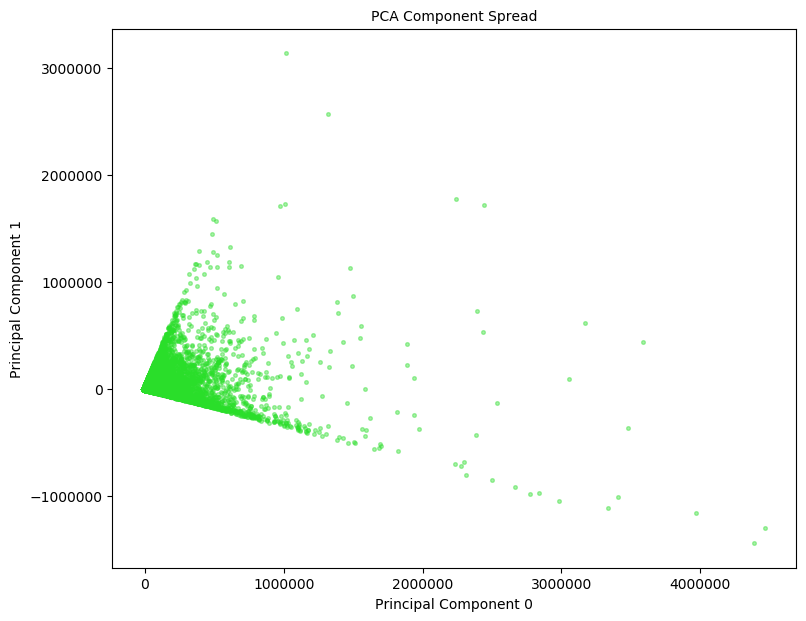

In [176]:
fig = plt.figure(figsize= (30, 7))

ax = fig.add_subplot(131) # PCA linear data
ax.scatter(train_pca[:,0], train_pca[:,1], marker= '.', color= '#2ade2a', s= 28, alpha= 0.4)
ax.set_title("PCA Component Spread", fontsize= 10)
ax.set_xlabel("Principal Component 0", fontsize= 10)
ax.set_ylabel("Principal Component 1", fontsize= 10)
plt.show()

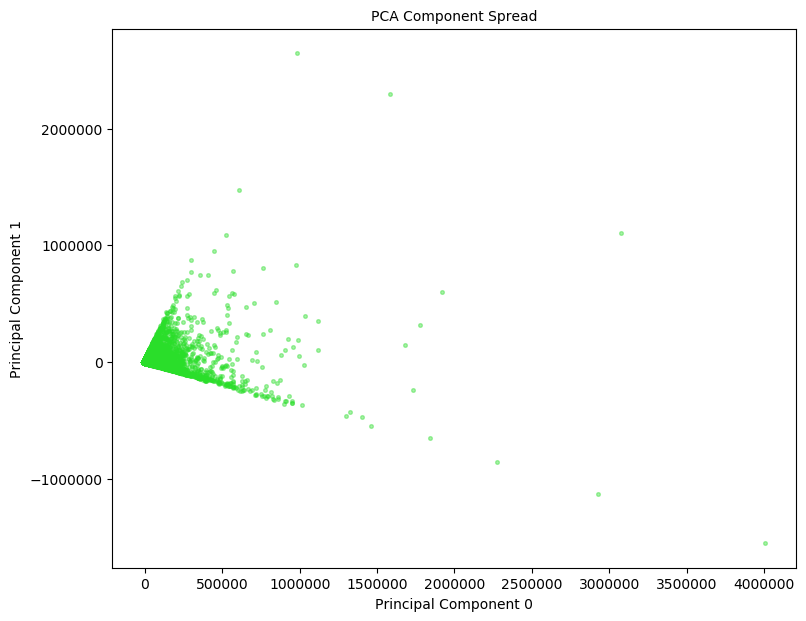

In [177]:
fig = plt.figure(figsize= (30, 7))

ax = fig.add_subplot(131) # PCA linear data
ax.scatter(test_pca[:,0], test_pca[:,1], marker= '.', color= '#2ade2a', s= 28, alpha= 0.4)
ax.set_title("PCA Component Spread", fontsize= 10)
ax.set_xlabel("Principal Component 0", fontsize= 10)
ax.set_ylabel("Principal Component 1", fontsize= 10)
plt.show()